# Subduction Zone Benchmark

## A Revised Benchmark

The community subduction zone benchmark [van Keken et al, 2008](http://dx.doi.org/10.1016/j.pepi.2008.04.015) provides a set of simplified models well suited to test the accuracy of the solution of the governing equations that are relevant for subduction zones. Unfortunately, the model geometry and assumptions that were chosen at the time are such that they introduce a few artifacts that do not occur, as best as we know, in any subduction zone on Earth. These artifacts include a slab that dips at a constant angle of 45$^\circ$ to 600 km depth, an overriding plate that excludes continental heat production,  and imposes slab-wedge coupling at 50 km rather than at 75-80 km depth.  The lack of crustal heating and the large width of the model, combined with the assumption of steady state, lead in the cases with temperature-dependent rheology to a very thick top boundary layer. This is caused by the cooling in the lithosphere, which results in a gradual thickening of the overriding lid in regions of the model that are far away from the arc-side boundary condition. While this is less of a problem in time-dependent problems (where time may not be sufficient for significant growth of the boundary layer), it shows up dramatically as a "viscous belly" in steady-state cases when the model domain is large. In time-dependent models it can show up if integration time is very long compared to the typical age of subduction zones.  The models in [Syracuse et al., 2010](http://dx.doi.org/10.1016/j.pepi.2010.02.004) avoided this issue by using time integration to 
only $\sim$20-40 Myr.  The models in [Wada & Wang, 2009](http://dx.doi.org/10.1029/2009GC002570) avoided it using steady-state models in a domain that is both narrower and shallower.


To mitigate the artifacts of the previous benchmark [Wilson & van Keken, 2023](http://dx.doi.org/10.1186/s40645-023-00588-6) proposed a new benchmark model. Modifications include a more shallowly dipping slab that only extends to a depth of 200 km, the incorporation of radiogenic heating in the overriding crust and a deeper slab-wedge coupling point. The geometry is still highly simplified:
![Figure 1a of Wilson & van Keken, 2023](benchmarkgeometry.png)
with a constant slab dip 
$\Delta=\tan^{-1}(1/2)=26.56505^\circ$ with respect to the horizontal.
The maximum depth $D$=200 defines $L$=400. 
The benchmark assumes ocean-continent subduction with heat production in a two-layer crust with crustal density and thermal conductivity ($\rho_c$ and $k_c$ respectively) distinct from the mantle ($\rho_m$ and $k_m$) and a backarc boundary condition on temperature. 
Upper and lower crustal depths, $z_1$ and $z_2$, are chosen as 15 and 40 respectively. 
$z_\text{io}$ depends on wedge geometry and rheology and is therefore variable between models, though as long as $z_\text{io}$ is larger than the depth where the actual switch between inflow and outflow occurs nearly identical solutions can be obtained.


We will assume the reference values given in Table 2 of [Wilson & van Keken, 2023](http://dx.doi.org/10.1186/s40645-023-00588-6) with case-specific parameters: 

| case | type | $\eta$ | $q_s^*$   | $A^*$ | $z_2$ | $z_\text{io}$ | $z_\text{trench}$ | $x_\text{coast}$ | $D$ | $L$ | $V_s^*$ |
| ---- | ---- | ------ | --------- | ----- | ----- | ------------- | ----------------- | ---------------- | --- | --- | ------- |
|      |      |        | (W/m$^2$) | (Myr) |       |               |                   |                  |     |     | (mm/yr) |
| 1    | continental    | 1      | 0.065     | 100   | 40    | 139           | 0                 | 0                | 200 | 400 | 100     |
| 2    | continental    | $\eta_\text{disl}$ | 0.065 | 100 | 40 | 154        | 0                 | 0                | 200 | 400 | 100     |

We will solve two sets of Stokes equations in the wedge (beneath the crust but above the slab surface) and slab (beneath the slab surface) subdomains respectively, either with constant viscosity ($\eta$=1, case 1) or with temperature- and strain-rate-dependent dislocation creep viscosity (case 2). Coupling between the slab velocity and the mantle wedge velocity starts at the partial coupling depth, $d_c$=80 km, and ramps up linearly to full coupling at the full coupling depth, $d_{fc}$=82.5 km and will be imposed through an internal boundary condition on the slab surface. The heat equation will be solved in the entire domain under the assumption of steady state.

Though this setup is designed for the benchmark cases, we will implement the problem in a manner that can be used for a range of subduction zone geometries, albeit with an inaccurate assumption of a steady state.

## Implementation

### Preamble

Let's start by adding the path to the modules in the `python` folder to the system path.  Also set the filename for the default parameters in the `data` directory.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.pardir, 'python'))
params_filename = os.path.join(os.pardir, "data", "default_params.json")

Then let's load all the required modules at the beginning.

In [2]:
import geometry as geo
import utils
from mpi4py import MPI
import dolfinx as df
import dolfinx.fem.petsc
import numpy as np
import scipy as sp
import ufl
import basix.ufl as bu
import matplotlib.pyplot as pl
import json
import copy
import pathlib

Now we can load the `default_params` dictionary from file.

In [3]:
with open(params_filename, "r") as fp:
    default_params = json.load(fp)

This contains default parameters required to define the geometry.  Keys ending in `_sid` and `_rid` are surface and region IDs respectively that we use to identify boundaries and regions of the mesh (these are unlikely to need to be changed).  `*_res_fact` are resolution factors scaled by a factor to set the resolution at various points in the mesh.  Finally, those ending in `_depth` are depths (in km) of various important points along the slab surface or boundaries.

In [4]:
print("{:<35} {:<10}".format('Key','Value'))
print("-"*45)
for k, v in default_params.items():
    print("{:<35} {:<10}".format(k, v))

Key                                 Value     
---------------------------------------------
slab_sid                            1         
slab_side_sid                       2         
wedge_side_sid                      3         
upper_wedge_side_sid                4         
lc_side_sid                         5         
uc_side_sid                         6         
slab_base_sid                       7         
wedge_base_sid                      8         
lc_base_sid                         9         
uc_base_sid                         10        
coast_sid                           11        
top_sid                             12        
fault_sid                           13        
slab_diag_sid                       14        
slab_rid                            1         
wedge_rid                           2         
lc_rid                              3         
uc_rid                              4         
wedge_diag_rid                      5         
slab_det_depth

### Describing the geometry

Even in the simplified benchmark case, the geometry of a subduction zone is more complicated than any of the in built meshes provided to us by `dolfinx`.  In kinematic slab models we need to describe the slab and the surrounding domain around it, including crustal layers and surface features.  We are particularly interested in the dynamics near the mantle wedge corner in the sub-arc region so will likely want to employ variable resolutions, with refined cells in this area.  Luckily, finite elements excel at describing these more complicated, variable resolution geometries using unstructured meshes.  We will start by describing the slab geometry.

#### Slab geometry

In kinematic slab models the slab is typically described using a small number of points derived from seismic data which are then fitted with a spline to interpolate and extrapolate the geometry to other depths.  We will use a cubic spline provided by the [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) module and wrapped for convenience in our own `geometry.py` python module.  We need to provide the points describing the spline, some information about the resolution we desire in the mesh at various points along the spline, and information about some points that we require to be included in the spline.  The most important of these are the partial and full coupling depths (`partial_coupling_depth` and `full_coupling_depth` in `default_params` respectively), which will later be used as the locations where the slab becomes fully coupled to the mantle wedge.  These parameters are key in determining the subduction zone thermal structure.  We also include a point at `slab_det_depth` that we use to extract diagnostic information.

We set up the slab using the function `create_slab` below.

In [5]:
def create_slab(xs, ys, resscale, lc_depth, 
                **kwargs):
    """
    Function to construct and return a spline object that is used to describe a subducting slab
    in a kinematic-slab model of a subduction zone.  Optional keyword arguments default to parameters 
    in the global default_params dictionary if not specified.
    
    Arguments:
      * xs             - list of x points in slab spline
      * ys             - list of y points in slab spline (must be the same length as xs)
      * resscale       - resolution scale factor that multiplies all _res_fact parameters
      * lc_depth       - depth of lower crustal boundary ("Moho")

    Keyword Arguments:
     distances:
      * slab_diag1_depth - starting depth of slab diagnostic region
      * slab_diag2_depth - end depth of slab diagnostic region
      * partial_coupling_depth - partial coupling depth on slab
      * full_coupling_depth    - full coupling depth on slab
      * slab_det_depth         - detector depth on slab

     resolutions factors (that get multiplied by the resscale to get the resolutions):
      * slab_diag1_res_fact             - start of slab diagnostic region
      * slab_diag2_res_fact             - end of slab diagnostic region
      * partial_coupling_depth_res_fact - partial coupling depth on slab
      * full_coupling_depth_res_fact    - full coupling depth on slab

     surface ids:
      * fault_sid            - fault
      * slab_sid             - default slab surface id
      * slab_diag_sid        - diagnostic region of slab

    Returns:
      * slab - subduction zone slab spline instance
    """
    
    # get input parameters
    # depths
    slab_diag1_depth       = kwargs.get('slab_diag1_depth', default_params['slab_diag1_depth'])
    slab_diag2_depth       = kwargs.get('slab_diag2_depth', default_params['slab_diag2_depth'])
    partial_coupling_depth = kwargs.get('partial_coupling_depth', default_params['partial_coupling_depth'])
    full_coupling_depth    = kwargs.get('full_coupling_depth', default_params['full_coupling_depth'])
    slab_det_depth         = kwargs.get('slab_det_depth', default_params['slab_det_depth'])
    
    # resolutions
    slab_diag1_res             = kwargs.get('slab_diag1_res_fact', default_params['slab_diag1_res_fact'])*resscale
    slab_diag2_res             = kwargs.get('slab_diag2_res_fact', default_params['slab_diag2_res_fact'])*resscale
    partial_coupling_depth_res = kwargs.get('partial_coupling_depth_res_fact', default_params['partial_coupling_depth_res_fact'])*resscale
    full_coupling_depth_res    = kwargs.get('full_coupling_depth_res_fact', default_params['full_coupling_depth_res_fact'])*resscale

    # surface ids
    fault_sid      = kwargs.get('fault_sid', default_params['fault_sid'])
    slab_sid       = kwargs.get('slab_sid', default_params['slab_sid'])
    slab_diag_sid  = kwargs.get('slab_diag_sid', default_params['slab_diag_sid'])
       
    # set up resolutions along the slab depending on depth
    # high resolution at shallow depths, lower resolution below the "diagnostic"
    # region required in the benchmark case
    # FIXME: these are currently hard-coded relative to the resolutions specified at the partial and full coupling
    # depths for simplicity but could be separate parameters
    res = [partial_coupling_depth_res if y >= -slab_diag2_depth else 3*full_coupling_depth_res for y in ys]
    
    # set up the surface ids for the slab depending on depth
    # above the "Moho" use fault_sid
    # in the diagnostic region use the slab_diag_sid
    # everywhere else use the default slab_sid
    sids = []
    for y in ys[1:]:
        if y >= -lc_depth: 
            sid = fault_sid
        elif y >= -slab_diag1_depth:
            sid = slab_sid
        elif y >= -slab_diag2_depth:
            sid = slab_diag_sid
        else:
            sid = slab_sid
        sids.append(sid)
    
    # set up the slab spline object
    slab = geo.SlabSpline(xs, ys, res=res, sid=sids, name="Slab")

    assert full_coupling_depth > partial_coupling_depth
    # adding the coupling depths may or may not be necessary
    # depending on if they were included in the slab spline data already or not
    # the slab class should ignore them if they aren't necessary
    slab.addpoint(partial_coupling_depth, "Slab::PartialCouplingDepth", 
                  res=partial_coupling_depth_res, 
                  sid=slab_diag_sid)
    slab.addpoint(full_coupling_depth, "Slab::FullCouplingDepth", 
                  res=full_coupling_depth_res, 
                  sid=slab_diag_sid)
    # add the slab detector point
    slab.addpoint(slab_det_depth, "Slab::DetectorPoint", 
                  res=full_coupling_depth_res,
                  sid=slab_diag_sid)

    # and return it
    return slab

Describing the slab geometry only takes a few non-default parameters, which are relatively simple in the benchmark geometry.

Although the resolution of our mesh is going to vary across the domain we will use a resolution scale factor `resscale` to scale the resolution globally, while different points in the domain retain the same default relative resolutions.  So a large `resscale` means low resolution and a small `resscale` means high resolution.

```{admonition} Computational cost
Setting the `resscale` too low will result in a computationally expensive simulation, especially in the non-linear case, that may need to be run locally rather than remotely.
```

In [6]:
resscale = 5.0

The benchmark slab geometry is rather simple, just consisting of a straight line with 2:1 horizontal distance to depth ratio, extending to 200km depth.  We can therefore just provide the spline with a series of linearly related points `xs` and `ys`.

In [7]:
# points in slab (just linear)
xs = [0.0, 140.0, 240.0, 400.0]
ys = [0.0, -70.0, -120.0, -200.0]

To get the surface ids on the slab correct we also have to provide the lower crustal depth `lc_depth`.  As this is a case dependent parameter it is not provided in `default_params`.  For the benchmark cases it is at 40km depth.

In [8]:
lc_depth = 40

Providing these parameters we can create our slab geometry.

In [9]:
slab = create_slab(xs, ys, resscale, lc_depth)

We can double check that it looks as expected by plotting the slab, though in the benchmark case this is not very interesting!

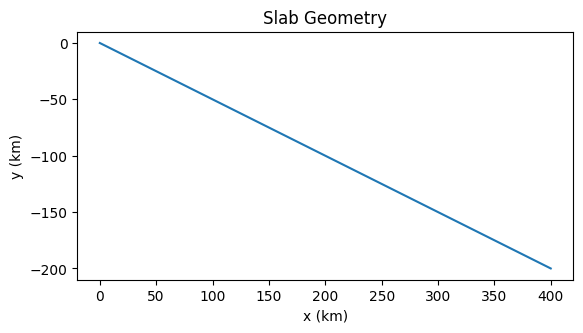

In [10]:
interpx = [curve.points[0].x for curve in slab.interpcurves]+[slab.interpcurves[-1].points[1].x]
interpy = [curve.points[0].y for curve in slab.interpcurves]+[slab.interpcurves[-1].points[1].y]
pl.plot(interpx, interpy)
pl.gca().set_xlabel('x (km)')
pl.gca().set_ylabel('y (km)')
pl.gca().set_aspect('equal')
_ = pl.gca().set_title('Slab Geometry')

With the slab geometry in hand we can move onto defining the rest of the geometry.

#### Subduction zone geometry

To describe the subduction zone geometry we need to build a two-dimensional domain around the slab spline.  In the simplest case this is simply a rectangle around the spline but more generally will include a sloping coastline, a crust and potentially an upper crust if the slab is subducting beneath a continent.  As with the spline we will also include certain important points in the domain and extra boundaries (lines) demarking special diagnostic regions of interest in the model.  Also as with the spline we use a python class implemented in our own `geometry.py` module to do most of the work.

In the following `create_sz_geometry` function we use the `slab` object we instantiated above to provide the bounds and set up a base `SubductionGeometry` object, which will essentially describe the bounding domain with a sloping coastline if `coast_distance > 0`.  The domain can also be set up to overshoot the lowermost end of the slab spline using the `extra_width` parameter.  Crustal layers will then be added to the domain, controlled by the `lc_depth`, `uc_depth` and `sztype` parameters (with the latter controlling how many layers are added).  The approximate point where the flow into and out of the wedge changes direction is included in the domain as specified by `io_depth`.  Finally, we subdivide the wedge into a "diagnostic" region where certain benchmark values can be easily calculated.  And, once again we use the same `resscale` parameter to scale the global resolution.

In [11]:
def create_sz_geometry(slab, resscale, sztype, io_depth, extra_width, 
                       coast_distance, lc_depth, uc_depth, 
                       **kwargs):
    """
    Function to construct and return a subduction zone geometry object that is used to generate
    a mesh of a subduction zone.  Optional keyword arguments default to parameters in the global 
    default_params dictionary if not specified.
    
    Arguments:
      * slab           - an instance of a slab spline object
      * resscale       - resolution scale factor that multiplies all _res_fact parameters
      * sztype         - either 'continental' or 'oceanic', which determines if an upper crust is included
      * io_depth       - prescribed input/output depth on wedge side
      * extra_width    - extra width at the base of the domain
      * coast_distance - distance from trench to coast
      * lc_depth       - depth of lower crustal boundary ("Moho")
      * uc_depth       - depth of upper crustal boundary

    Keyword Arguments:
     distances:
      * slab_diag1_depth - starting depth along slab of slab diagnostic region
      * slab_diag2_depth - end depth along slab of slab diagnostic region

     resolutions factors (that get multiplied by the resscale to get the resolutions):
      * io_depth_res_fact        - input/output depth
      * coast_res_fact           - coastal point on top
      * lc_slab_res_fact         - lower crust slab intersection
      * lc_side_res_fact         - lower crust side intersection
      * uc_slab_res_fact         - upper crust slab intersection
      * uc_side_res_fact         - upper crust side intersection
      * slab_diag1_res_fact      - start of slab diagnostic region
      * slab_diag2_res_fact      - end of slab diagnostic region
      * wedge_side_top_res_fact  - top of the wedge side
      * wedge_side_base_res_fact - base of the wedge side
      * slab_side_base_res_fact  - base of the slab side

     surface ids:
      * coast_sid            - coastal slope
      * top_sid              - top of domain
      * fault_sid            - fault
      * lc_side_sid          - side of lower crust
      * lc_base_sid          - base of lower crust
      * uc_side_sid          - side of upper crust
      * uc_base_sid          - base of upper crust
      * slab_sid             - default slab surface id
      * slab_diag_sid        - diagnostic region of slab
      * slab_side_sid        - side of slab
      * wedge_side_sid       - side of wedge
      * upper_wedge_side_sid - side of upper wedge
      * slab_base_sid        - base of slab
      * wedge_base_sid       - base of wedge

     region ids:
      * slab_rid       - slab
      * wedge_rid      - wedge
      * lc_rid         - lower crust
      * uc_rid         - upper crust
      * wedge_diag_rid - wedge diagnostic region

    Returns:
      * geom - subduction zone geometry class instance
    """

    # get input parameters
    # depths
    slab_diag1_depth = kwargs.get('slab_diag1_depth', default_params['slab_diag1_depth'])
    slab_diag2_depth = kwargs.get('slab_diag2_depth', default_params['slab_diag2_depth'])
    
    # resolutions
    io_depth_res = kwargs.get('io_depth_res_fact', default_params['io_depth_res_fact'])*resscale
    coast_res   = kwargs.get('coast_res_fact', default_params['coast_res_fact'])*resscale
    lc_slab_res = kwargs.get('lc_slab_res_fact', default_params['lc_slab_res_fact'])*resscale
    lc_side_res = kwargs.get('lc_side_res_fact', default_params['lc_side_res_fact'])*resscale
    uc_slab_res = kwargs.get('uc_slab_res_fact', default_params['uc_slab_res_fact'])*resscale
    uc_side_res = kwargs.get('uc_side_res_fact', default_params['uc_side_res_fact'])*resscale
    slab_diag1_res = kwargs.get('slab_diag1_res_fact', default_params['slab_diag1_res_fact'])*resscale
    slab_diag2_res = kwargs.get('slab_diag2_res_fact', default_params['slab_diag2_res_fact'])*resscale
    wedge_side_top_res  = kwargs.get('wedge_side_top_res_fact', default_params['wedge_side_top_res_fact'])*resscale
    wedge_side_base_res = kwargs.get('wedge_side_base_res_fact', default_params['wedge_side_base_res_fact'])*resscale
    slab_side_base_res  = kwargs.get('slab_side_base_res_fact', default_params['slab_side_base_res_fact'])*resscale

    # surface ids
    coast_sid = kwargs.get('coast_sid', default_params['coast_sid'])
    top_sid   = kwargs.get('top_sid', default_params['top_sid'])
    fault_sid = kwargs.get('fault_sid', default_params['fault_sid'])
    lc_side_sid = kwargs.get('lc_side_sid', default_params['lc_side_sid'])
    lc_base_sid = kwargs.get('lc_base_sid', default_params['lc_base_sid'])
    uc_side_sid = kwargs.get('uc_side_sid', default_params['uc_side_sid'])
    uc_base_sid = kwargs.get('uc_base_sid', default_params['uc_base_sid'])
    slab_sid    = kwargs.get('slab_sid', default_params['slab_sid'])
    slab_diag_sid  = kwargs.get('slab_diag_sid', default_params['slab_diag_sid'])
    slab_side_sid  = kwargs.get('slab_side_sid', default_params['slab_side_sid'])
    wedge_side_sid = kwargs.get('wedge_side_sid', default_params['wedge_side_sid'])
    slab_base_sid  = kwargs.get('slab_base_sid', default_params['slab_base_sid'])
    wedge_base_sid = kwargs.get('wedge_base_sid', default_params['wedge_base_sid'])
    upper_wedge_side_sid = kwargs.get('upper_wedge_side_sid', default_params['upper_wedge_side_sid'])
    
    # region ids
    slab_rid       = kwargs.get('slab_rid', default_params['slab_rid'])
    wedge_rid      = kwargs.get('wedge_rid', default_params['wedge_rid'])
    lc_rid         = kwargs.get('lc_rid', default_params['lc_rid'])
    uc_rid         = kwargs.get('uc_rid', default_params['uc_rid'])
    wedge_diag_rid = kwargs.get('wedge_diag_rid', default_params['wedge_diag_rid'])
    
    assert sztype in ['continental', 'oceanic']
    

    # pass the slab object into the SubductionGeometry class to construct the geometry
    # around it
    geom = geo.SubductionGeometry(slab, 
                                  coast_distance=coast_distance, 
                                  extra_width=extra_width, 
                                  slab_side_sid=slab_side_sid, 
                                  wedge_side_sid=wedge_side_sid, 
                                  slab_base_sid=slab_base_sid, 
                                  wedge_base_sid=wedge_base_sid, 
                                  coast_sid=coast_sid, 
                                  top_sid=top_sid, 
                                  slab_rid=slab_rid, 
                                  wedge_rid=wedge_rid, 
                                  coast_res=coast_res, 
                                  slab_side_base_res=slab_side_base_res, 
                                  wedge_side_top_res=wedge_side_top_res, 
                                  wedge_side_base_res=wedge_side_base_res)

    if sztype=='oceanic':
        # add a single crust layer
        # (using the lc parameters & ignoring the uc ones)
        geom.addcrustlayer(lc_depth, "Crust",
                           sid=lc_base_sid, rid=lc_rid,
                           slab_res=lc_slab_res,
                           side_res=lc_side_res,
                           slab_sid=fault_sid,
                           side_sid=lc_side_sid)
    else:
        # add a lower crust
        geom.addcrustlayer(lc_depth, "Crust", 
                           sid=lc_base_sid, rid=lc_rid,
                           slab_res=lc_slab_res,
                           side_res=lc_side_res,
                           slab_sid=fault_sid,
                           side_sid=lc_side_sid)
        
        # add an upper crust
        geom.addcrustlayer(uc_depth, "UpperCrust", 
                           sid=uc_base_sid, rid=uc_rid,
                           slab_res=uc_slab_res,
                           side_res=uc_side_res,
                           slab_sid=fault_sid,
                           side_sid=uc_side_sid)
    
    # add the pre-defined in-out point on the wedge side
    geom.addwedgesidepoint(io_depth, "WedgeSide::InOut", line_name="UpperWedgeSide", 
                           res=io_depth_res, 
                           sid=upper_wedge_side_sid)
    
    # add wedge dividers for the diagnostics
    geom.addwedgedivider(slab_diag1_depth, "ColdCorner", 
                         slab_res=slab_diag2_res, 
                         top_res=slab_diag2_res,
                         rid=wedge_rid, 
                         slab_sid=slab_sid)
    
    # add wedge dividers for the diagnostics
    geom.addwedgedivider(slab_diag2_depth, "WedgeFocused", 
                         slab_res=slab_diag1_res, 
                         top_res=slab_diag1_res,
                         rid=wedge_diag_rid, 
                         slab_sid=slab_diag_sid)

    # return the geometry object
    return geom

For the benchmark cases we do not include a coastline or any extra width beyond the slab so `coast_distance = 0` and `extra_width = 0`.  The subduction zone "type" is continental (`sztype = "continental"`), which means we need to set an upper crustal depth, which in the benchmark is 40km, `uc_depth = 40`.  `lc_depth` was already set when describing the slab.

In [12]:
coast_distance = 0
extra_width = 0
uc_depth = 15
sztype = 'continental'

The input/output depth varies between the isoviscous (case 1) and nonlinear (case 2) benchmarks. We choose the value from case 1 here.

In [13]:
io_depth_1 = 139

Leaving all other parameters as their default values we can now instantiate a subduction zone geometry object.

In [14]:
geom = create_sz_geometry(slab, resscale, sztype, io_depth_1, extra_width, 
                          coast_distance, lc_depth, uc_depth)

And examine it to see if it looks correct.

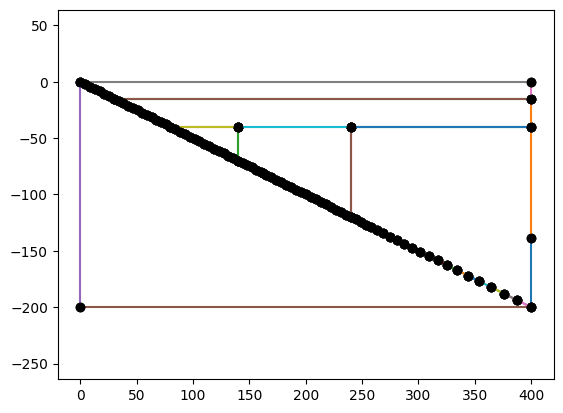

In [15]:
geom.plot(label_sids=False, label_rids=False)

The finished geometry object can now be used to generate the mesh we will use to solve our numerical problem.  To do this we are using [GMsh](https://gmsh.info/) in the background, which can generate a lot of output.

In [16]:
mesh, cell_tags, facet_tags = geom.generatemesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
I

Once the mesh (`mesh`) and mesh tag objects (`cell_tags` and `facet_tags`) are generated we can visualize the resulting unstructured triangular mesh.

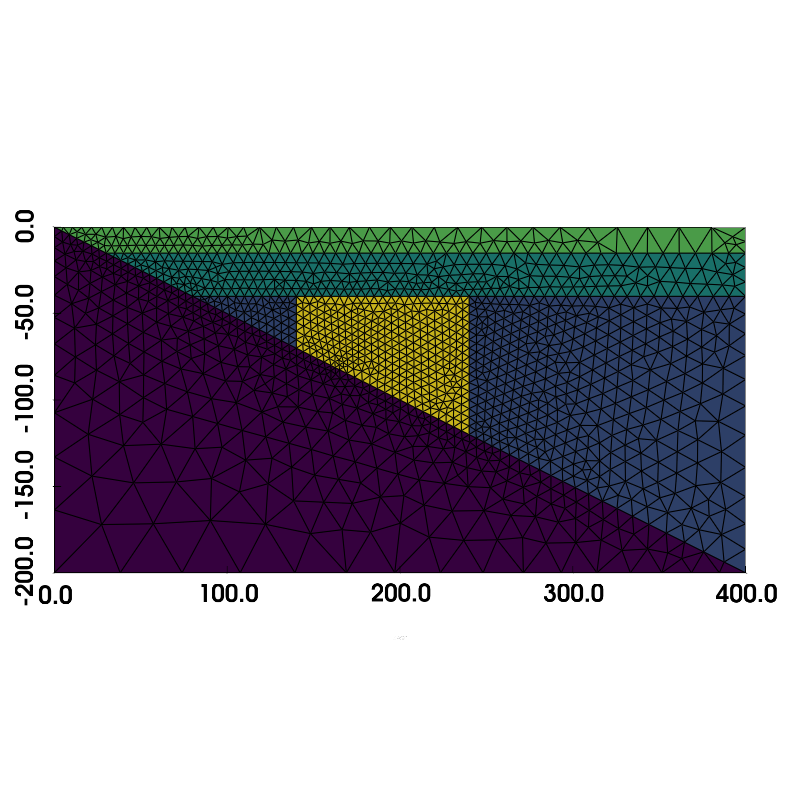

In [17]:
utils.plot_mesh(mesh, cell_tags)

It's also possible to output the geometry to file using
```
output_folder = pathlib.Path("output")
output_folder.mkdir(exist_ok=True, parents=True)
filename = output_folder / "<file base name>"
geom.writegeofile(str(filename.with_suffix('.geo_unrolled')))
```

where `<file base name>` needs to be replaced.

With the geometry (and mesh!) in hand it's possible to move onto describing the physical problem we want to solve.

### Kinematic slab model

To describe a kinematic slab subduction zone model we are going to build up a `SubductionProblem` python class that will take in the subduction zone geometry object we just created and use it to set up finite element function spaces and apply appropriate boundary conditions to the resulting finite element Functions.  Once this preliminary setup is taken care of we will describe the mathematical problem we wish to solve and provide finite element forms to the class to solve.  These will depend on the rheology we assume.  Benchmark case 1 uses a simple isoviscous rheology while case 2 uses a dislocation creep viscosity.

To build the python class in an parseable way we will be using some python trickery, rederiving the class in each cell, which isn't really how this would be done outside of a Jupyter notebook.  We being by declaring the class and its members.  Those initialized to `None` need to be initialized in the class routines that we will describe in the following cells.  Others are initialized to appropriate default values.  Only the first few are intended to be modified and we will write functions to allow us to do this later.

#### The `SubductionProblem` class

In [18]:
class SubductionProblem:
    """
    A class describing a kinematic slab subduction zone thermal problem.
    """
    
    # geometry object
    geom = None

    # case specific
    A      = None      # age of subducting slab (Myr)
    Vs     = None      # slab speed (mm/yr)
    sztype = None      # type of sz ('continental' or 'oceanic')
    Ac     = None      # age of over-riding plate (Myr) - oceanic only
    As     = None      # age of subduction (Myr) - oceanic only
    qs     = None      # surface heat flux (W/m^2) - continental only
    
    # non-dim parameters
    Ts      = 0.0       # surface temperature (non-dim, also deg C)
    Tm      = 1350.0    # mantle temperature (non-dim, also deg C)
    kc      = 0.8064516 # crustal thermal conductivity (non-dim)
    km      = 1.0       # mantle thermal conductivity (non-dim)
    rhoc    = 0.8333333 # crustal density (non-dim)
    rhom    = 1.0       # mantle density (non-dim)
    cp      = 1.0       # heat capacity (non-dim)
    H1      = 0.419354  # upper crustal volumetric heat production (non-dim) 
    H2      = 0.087097  # lower crustal volumetric heat production (non-dim)

    # dislocation creep parameters
    etamax = 1.0e25    # maximum viscosity (Pa s)
    nsigma = 3.5       # stress viscosity power law exponent (non-dim)
    Aeta   = 28968.6   # pre-exponential viscosity constant (Pa s^(1/nsigma))
    E      = 540.0e3   # viscosity activation energy (J/mol)
    
    # finite element degrees
    p_p = 1
    p_T = 2

    # only allow these options to be set from the update and __init__ functions
    allowed_input_parameters = ['A', 'Vs', 'sztype', 'Ac', 'As', 'qs', \
                                'Ts', 'Tm', 'kc', 'km', 'rhoc', 'rhom', 'cp', 'H1', 'H2', \
                                'etamax', 'nsigma', 'Aeta', 'E', \
                                'p_p', 'p_T']

    required_parameters     = ['A', 'Vs', 'sztype']
    required_if_continental = ['qs']
    required_if_oceanic     = ['Ac', 'As']

    # reference values
    k0     = 3.1       # reference thermal conductivity (W/m/K)
    rho0   = 3300.0    # reference density (kg/m^3)
    cp0    = 1250.0    # reference heat capacity (J/kg/K)
    h0     = 1000.0    # reference length scale (m)
    eta0   = 1.0e21    # reference viscosity (Pa s)
    T0     = 1.0       # reference temperature (K)
    R      = 8.3145    # gas constant (J/mol/K)

    # derived reference values
    kappa0 = None  # reference thermal diffusivity (m^2/s)
    v0     = None  # reference velocity (m/s)
    t0     = None  # reference time-scale (s)
    e0     = None  # reference strain rate (/s)
    p0     = None  # reference pressure (Pa)
    H0     = None  # reference heat source (W/m^3)
    q0     = None  # reference heat flux (W/m^2)
    
    # derived parameters
    A_si   = None  # age of subducting slab (s)
    Vs_nd  = None  # slab speed (non-dim)
    Ac_si  = None  # age of over-riding plate (s) - oceanic only
    As_si  = None  # age of subduction (s) - oceanic only
    qs_nd  = None  # surface heat flux (non-dim) - continental only

    # derived from the geometry object
    deltaztrench = None
    deltaxcoast  = None
    deltazuc     = None
    deltazc      = None

    # mesh related
    mesh       = None
    cell_tags  = None
    facet_tags = None

    # dimensions and mesh statistics
    gdim = None
    tdim = None
    fdim = None
    num_cells = None

    # integral measures
    dx = None
    dS = None

    # region ids
    wedge_rids       = None
    slab_rids        = None
    crust_rids       = None

    # wedge submesh
    wedge_submesh    = None
    wedge_cell_tags  = None
    wedge_facet_tags = None 
    wedge_cell_map   = None
    wedge_reverse_cell_map = None

    # slab submesh
    slab_submesh    = None
    slab_cell_tags  = None
    slab_facet_tags = None
    slab_cell_map   = None
    slab_reverse_cell_map = None

    # functionspaces
    Vslab_vp  = None
    Vslab_v   = None
    Vwedge_vp = None
    Vwedge_v  = None
    V_T       = None

    # functions
    slab_vps_i  = None
    wedge_vpw_i = None
    T_i         = None

    # functions that need interpolation
    vs_i      = None
    ps_i      = None
    vw_i      = None
    pw_i      = None
    slab_T_i  = None
    wedge_T_i = None

    # sub (split) functions
    slab_vs_i  = None
    slab_ps_i  = None
    wedge_vw_i = None
    wedge_pw_i = None

    # test functions
    slab_vps_t = None
    wedge_vw_i = None
    T_t        = None

    # trial functions
    slab_vps_a  = None
    wedge_vpw_a = None
    T_a         = None
    
    # boundary conditions
    bcs_T   = None # temperature
    bcs_vpw = None # wedge velocity/pressure
    bcs_vps = None # slab velocity/pressure
    

Just as in simpler problems we first need to initialize the mesh.  We do this just as we did above, through the geometry object that we assume is available as a member of the class.

Here describing the geometry is further complicated by the fact that we will want to solve three problems:
1. a thermal problem across the whole domain (the slab, the mantle wedge and the crust)
2. a mechanical problem for the flow in the slab (just in the slab portion of the domain, beneath the slab surface)
3. a mechanical problem for the corner flow in the mantle wedge (just in the mantle wedge portion of the domain, above the slab surface)

Note that we do not solve a mechanical problem in the crust, which is assumed rigid (zero velocity) in the benchmark.

To facilitate these three problems we create:
* a mesh of the whole domain (for the thermal problem)

and extract from it:
* a submesh of the slab, and
* a submesh of the mantle wedge.

We also record various other pieces of information about the mesh, tags demarking different regions and boundaries, and maps to and from the submeshes.

In [19]:
class SubductionProblem(SubductionProblem):
    def setup_meshes(self):
        """
        Generate the mesh from the supplied geometry then extract submeshes representing
        the wedge and slab for the Stokes problems in these regions.
        """
        # check we have a geometry object attached
        assert self.geom is not None

        # generate the mesh using gmsh
        # this command also returns cell and facets tags identifying regions and boundaries in the mesh
        self.mesh, self.cell_tags, self.facet_tags = self.geom.generatemesh()

        # record the dimensions
        self.gdim = self.mesh.geometry.dim
        self.tdim = self.mesh.topology.dim
        self.fdim = self.tdim - 1

        self.dx = ufl.Measure("dx", domain=self.mesh, subdomain_data=self.cell_tags)
        self.dS = ufl.Measure("dS", domain=self.mesh, subdomain_data=self.facet_tags)

        # get the number of cells
        cell_imap = self.mesh.topology.index_map(self.tdim)
        self.num_cells = cell_imap.size_local + cell_imap.num_ghosts

        # record the region ids for the wedge, slab and crust based on the geometry
        self.wedge_rids = tuple(set([v['rid'] for k,v in self.geom.wedge_dividers.items()]+[self.geom.wedge_rid]))
        self.slab_rids  = tuple([geom.slab_rid])
        self.crust_rids = tuple(set([v['rid'] for k,v in geom.crustal_layers.items()]))

        # generate the wedge submesh
        # this command also returns cell and facet tags mapped from the parent mesh to the submesh
        # additionally a cell map maps cells in the submesh to the parent mesh
        self.wedge_submesh, self.wedge_cell_tags, self.wedge_facet_tags, self.wedge_cell_map = \
                            utils.create_submesh(self.mesh, np.concatenate([self.cell_tags.find(rid) for rid in self.wedge_rids]), \
                                                 self.cell_tags, self.facet_tags)
        # create a reverse cell map from the parent mesh to the submesh
        # (entering -1s in the map where no cell exists in the submesh)
        self.wedge_reverse_cell_map = np.full(self.num_cells, -1, dtype=np.int32)
        self.wedge_reverse_cell_map[self.wedge_cell_map] = np.arange(len(self.wedge_cell_map))

        
        # generate the slab submesh
        # this command also returns cell and facet tags mapped from the parent mesh to the submesh
        # additionally a cell map maps cells in the submesh to the parent mesh
        self.slab_submesh, self.slab_cell_tags, self.slab_facet_tags, self.slab_cell_map  = \
                            utils.create_submesh(self.mesh, np.concatenate([self.cell_tags.find(rid) for rid in self.slab_rids]), \
                                                 self.cell_tags, self.facet_tags)
        # create a reverse cell map from the parent mesh to the submesh
        # (entering -1s in the map where no cell exists in the submesh)
        self.slab_reverse_cell_map = np.full(self.num_cells, -1, dtype=np.int32)
        self.slab_reverse_cell_map[self.slab_cell_map] = np.arange(len(self.slab_cell_map))

With a mesh in hand we can initialize the functionspaces and dolfinx `Function`s that we will use to solve our problem.

We are going to be solving problems for:
* velocity in the wedge
* pressure in the wedge
* velocity in the slab
* pressure in the slab
* temperature in the full domain

and need to select appropriate finite elements for each.  We're going to use continuous "Lagrange" elements for all but the degree of the polynomials for velocity and pressure cannot be chosen independently but instead need to be selected as an appropriate mixed element pair for numerical stability reasons.  We're going to use a "Taylor-Hood" element pair, where the velocity degree is one higher than the pressure so only the pressure degree (`p_p`) can be set independently (and defaults to 1 so by default our element pair is known as P2-P1).  The temperature degree (`p_T`) can be set independently but a reasonable default is 2.

With appropriate finite elements selected we can declare functionspace and Functions on the various meshes.  Because our temperature problem will need access to the velocity and pressure from the submeshes, and vice versa, we declare multiple versions of each Function on each sub and parent mesh and will later use them to interpolate the values between the domains.

In [20]:
class SubductionProblem(SubductionProblem):
    def setup_functionspaces(self):
        """
        Set up the functionspaces for the problem.
        """
        # create finite elements for velocity and pressure
        # use a P2P1 (Taylor-Hood) element pair where the velocity
        # degree is one higher than the pressure (so only the pressure
        # degree can be set)
        v_e = bu.element("Lagrange", self.mesh.basix_cell(), self.p_p+1, shape=(self.gdim,), dtype=df.default_real_type)
        p_e = bu.element("Lagrange", self.mesh.basix_cell(), self.p_p, dtype=df.default_real_type)
        # combine them into a mixed finite element
        vp_e = bu.mixed_element([v_e, p_e])
        
        def create_vp_functions(mesh, name_prefix):
            """
            Create velocity and pressure functions
            """
            # set up the mixed velocity, pressure functionspace
            V_vp = df.fem.functionspace(mesh, vp_e)
            # set up a collapsed velocity functionspace
            V_v, _ = V_vp.sub(0).collapse()

            # set up a mixed velocity, pressure function
            vp_i = df.fem.Function(V_vp)
            vp_i.name = name_prefix+"vp"
            # split the velocity and pressure subfunctions
            (v_i, p_i) = vp_i.split()
            v_i.name = name_prefix+"v"
            p_i.name = name_prefix+"p"
            # set up the mixed velocity, pressure test function
            vp_t = ufl.TestFunction(V_vp)
            # set up the mixed velocity, pressure trial function
            vp_a = ufl.TrialFunction(V_vp)

            # return everything
            return V_vp, V_v, vp_i, v_i, p_i, vp_t, vp_a
        
        # set up slab functionspace, collapsed velocity sub-functionspace, 
        # combined velocity-pressure Function, split velocity and pressure Functions,
        # and trial and test functions for
        # 1. the slab submesh
        self.Vslab_vp,  self.Vslab_v,  \
                        self.slab_vps_i, \
                        self.slab_vs_i, self.slab_ps_i, \
                        self.slab_vps_t, self.slab_vps_a = create_vp_functions(self.slab_submesh, "slab_")
        # 2. the wedge submesh
        self.Vwedge_vp, self.Vwedge_v, \
                        self.wedge_vpw_i, \
                        self.wedge_vw_i, self.wedge_pw_i, \
                        self.wedge_vpw_t, self.wedge_vpw_a = create_vp_functions(self.wedge_submesh, "slab_")

        # set up the mixed velocity, pressure functionspace (not stored)
        V_vp   = df.fem.functionspace(self.mesh, vp_e)
        V_v, _ = V_vp.sub(0).collapse()
        V_p, _ = V_vp.sub(1).collapse()

        # set up functions defined on the whole mesh
        # to interpolate the wedge and slab velocities
        # and pressures to
        self.vs_i = df.fem.Function(V_v)
        self.vs_i.name = "vs"
        self.ps_i = df.fem.Function(V_p)
        self.ps_i.name = "ps"
        self.vw_i = df.fem.Function(V_v)
        self.vw_i.name = "vw"
        self.pw_i = df.fem.Function(V_p)
        self.pw_i.name = "pw"
        
        # temperature element
        # the degree of the element can be set independently through p_T
        T_e = bu.element("Lagrange", self.mesh.basix_cell(), self.p_T, dtype=df.default_real_type)
        # and functionspace on the overall mesh
        self.V_T  = df.fem.functionspace(self.mesh, T_e)

        # create a dolfinx Function for the temperature
        self.T_i = df.fem.Function(self.V_T)
        self.T_i.name = "T"
        self.T_t = ufl.TestFunction(self.V_T)
        self.T_a = ufl.TrialFunction(self.V_T)
        
        # on the slab submesh
        Vslab_T = df.fem.functionspace(self.slab_submesh, T_e)
        # and on the wedge submesh
        Vwedge_T = df.fem.functionspace(self.wedge_submesh, T_e)
        # set up Functions so the solution can be interpolated to these subdomains
        self.slab_T_i  = df.fem.Function(Vslab_T)
        self.slab_T_i.name = "slab_T"
        self.wedge_T_i = df.fem.Function(Vwedge_T)
        self.wedge_T_i.name = "wedge_T"


Since we've just declared multiple Functions on multiple domains, let's set up some convenience python functions to performed the interpolations:
* from the global temperature to the temperature declared in the slab and wedge
* from the slab and wedge velocities to global versions of each
* from the slab and wedge pressures to the global versions of each

In [21]:
class SubductionProblem(SubductionProblem):
    def update_T_functions(self):
        """
        Update the temperature functions defined on the submeshes, given a solution on the full mesh.
        """
        self.slab_T_i.interpolate(self.T_i, cell_map=self.slab_cell_map)
        self.wedge_T_i.interpolate(self.T_i, cell_map=self.wedge_cell_map)
    
    def update_v_functions(self):
        """
        Update the velocity functions defined on the full mesh, given solutions on the sub meshes.
        """
        self.vs_i.interpolate(self.slab_vs_i, cells=self.slab_cell_map, cell_map=self.slab_reverse_cell_map)
        self.vw_i.interpolate(self.wedge_vw_i, cells=self.wedge_cell_map, cell_map=self.wedge_reverse_cell_map)

    def update_p_functions(self):
        """
        Update the pressure functions defined on the full mesh, given solutions on the sub meshes.
        """
        self.ps_i.interpolate(self.slab_ps_i, cells=self.slab_cell_map, cell_map=self.slab_reverse_cell_map)
        self.pw_i.interpolate(self.wedge_pw_i, cells=self.wedge_cell_map, cell_map=self.wedge_reverse_cell_map)


We now need to set up boundary conditions for our functions.

At the trench inflow boundary we assume a half-space cooling model $T_\text{trench}(z)$ given by
\begin{equation}
T(x=0, z) = T_\text{trench}(z) = T_s + (T_m - T_s ) {\rm erf} \left( \tfrac{z}{z_d} \right)
\end{equation}
where $z$ is depth below the surface, $T_s$ is the non-dimensional surface temperature, $T_m$ the non-dimensional mantle temperature, and the non-dimensional scale depth $z_d$ is proportional to the dimensional age of the incoming lithosphere 
$A^*$ via $z_d =  2 \tfrac{\sqrt{ \kappa_0 A^*}}{h_0} $, where $\kappa_0$ and $h_0$ are the reference diffusivity and lengthscale respectively.

In [22]:
class SubductionProblem(SubductionProblem):
    def T_trench(self, x):
        """
        Return temperature at the trench
        """
        zd = 2*np.sqrt(self.kappa0*self.A_si)/self.h0  # incoming slab scale depth (non-dim)
        deltazsurface = np.minimum(np.maximum(self.deltaztrench*(1.0 - x[0,:]/max(self.deltaxcoast, np.finfo(float).eps)), 0.0), self.deltaztrench)
        return self.Ts + (self.Tm-self.Ts)*sp.special.erf(-(x[1,:]+deltazsurface)/zd)


In the ocean-ocean (`sztype == "oceanic"`) subduction cases, the wedge inflow boundary condition on temperature down to $z_\textrm{io}$ (`io_depth`) is

\begin{equation}
T(x=L, z) = T_\text{backarc,o}(z) ~=~ T_s + (T_m - T_s ) {\rm erf} \left( \tfrac{z}{z_c} \right) 
\end{equation}

where $z_c$ is related to the dimensional age of the overriding plate 
$A_c^*$ minus the age of subduction $A_s^*$ via $z_c =  2 \tfrac{\sqrt{ \kappa_0 (A_c^*-A^*_s)}}{h_0} $.

In [23]:
class SubductionProblem(SubductionProblem):
    def T_backarc_o(self, x):
        """
        Return temperature at the trench
        """
        zc = 2*np.sqrt(self.kappa0*(self.Ac_si-self.As_si))/self.h0 # overriding plate scale depth (non-dim)
        deltazsurface = np.minimum(np.maximum(self.deltaztrench*(1.0 - x[0,:]/max(self.deltaxcoast, np.finfo(float).eps)), 0.0), self.deltaztrench)
        return self.Ts + (self.Tm-self.Ts)*sp.special.erf(-(x[1,:]+deltazsurface)/zc)


The benchmark cases are ocean-continent (`sztype == "continental"`) where the wedge inflow the boundary condition on temperature is chosen to be a geotherm $T_\text{backarc}(z)$ consistent with these parameters

\begin{equation}
T(x=L,z) = T_\text{backarc,c}(z) ~=~
 \left\{ \begin{array}{l@{\quad:\quad}l}
 T_s -\frac{H_1 z^2}{2 k_c}~+~\frac{q_s}{k_c}z  & z ~\in~ [0,z_1] \\
 T_\text{backarc,c}(z=z_1)-\frac{H_2 (z-z_1)^2}{2 k_c} ~+~\frac{q_1}{k_c}(z-z_1) &  z ~\in~ (z_1, z_2] \\
 \min(T_m,T_\text{backarc,c}(z=z_2)+\frac{q_2}{k_m}(z-z_2))& z ~\in~(z_2, z_{io}]
   \end{array}
  \right.
\end{equation}

The discrete heat flow values $q_i$ are the heat flow at the crustal boundaries at depth $z$=$z_i$ ($z_1$ being the upper crust boundary depth, `uc_depth`, and $z_2$ being the lower crust boundary depth, `lc_depth`)
that can be easily found as
$q_1=q_s-H_1 z_1$ and $q_2=q_1-H_2 (z_2-z_1)$. $H_1$ (`H1`), $H_2$ (`H2`), $k_c$ (`kc`) and $k_m$ (`km`) are the non-dimensional heat production in the upper and lower crusts and the non-dimensional thermal conductivities in the crust and mantle respectively.  Note that $q_s$ above is the non-dimensional surface heat flux that is related to the dimensional class parameter `qs` by dividing `qs` by a reference heat flux value.

In [24]:
class SubductionProblem(SubductionProblem):
    def T_backarc_c(self, x):
        """
        Return continental backarc temperature
        """
        T = np.empty(x.shape[1])
        deltazsurface = np.minimum(np.maximum(self.deltaztrench*(1.0 - x[0,:]/max(self.deltaxcoast, np.finfo(float).eps)), 0.0), self.deltaztrench)
        for i in range(x.shape[1]):
            if -(x[1,i]+deltazsurface[i]) < self.deltazuc:
                # if in the upper crust
                deltaz = -(x[1,i]+deltazsurface[i])
                T[i] = self.Ts - self.H1*(deltaz**2)/(2*self.kc) + (self.qs_nd/self.kc)*deltaz
            elif -(x[1,i]+deltazsurface[i]) < self.deltazc:
                # if in the lower crust
                deltaz1 = self.deltazuc #- deltazsurface[i]
                T1 = self.Ts - self.H1*(deltaz1**2)/(2*self.kc) + (self.qs_nd/self.kc)*deltaz1
                q1 = - self.H1*deltaz1 + self.qs_nd
                deltaz = -(x[1,i] + deltazsurface[i] + self.deltazuc)
                T[i] = T1 - self.H2*(deltaz**2)/(2*self.kc) + (q1/self.kc)*deltaz
            else:
                # otherwise, we're in the mantle
                deltaz1 = self.deltazuc # - deltazsurface[i]
                T1 = self.Ts - self.H1*(deltaz1**2)/(2*self.kc) + (self.qs_nd/self.kc)*deltaz1
                q1 = - self.H1*deltaz1 + self.qs_nd
                deltaz2 = self.deltazc - self.deltazuc #- deltazsurface[i]
                T2 = T1 - self.H2*(deltaz2**2)/(2*self.kc) + (q1/self.kc)*deltaz2
                q2 = - self.H2*deltaz2 + q1
                deltaz = -(x[1,i] + deltazsurface[i] + self.deltazc)
                T[i] = min(self.Tm, T2 + (q2/self.km)*deltaz)
        return T
        

The wedge flow, $\vec{v}_w$ (`wedge_vw_i`), is driven by the coupling of the slab to the wedge at coupling depth $z$=$d_c$ (`partial_coupling_depth` in the slab spline). Above the coupling depth the boundary condition is zero velocity. Below
the coupling depth the velocity is parallel to the slab and has non-dimensional magnitude $V_s$ (dimensional `Vs`, non-dimensional `Vs_nd`). A smooth 
transition from zero to full speed over a short depth interval 
enhances the accuracy of the Stokes solution so here coupling begins at $z$=$d_c$, ramping up linearly until full coupling is reached at $z$=$d_{fc}$ (`full_coupling_depth` in the slab spline, 2.5km lower than the partial coupling depth by default).

In [25]:
class SubductionProblem(SubductionProblem):
    def vw_slabtop(self, x):
        """
        Return the wedge velocity on the slab surface
        """
        # grab the partial and full coupling depths so we can set up a linear ramp in velocity between them
        pcd = -self.geom.slab_spline.findpoint("Slab::PartialCouplingDepth").y
        fcd = -self.geom.slab_spline.findpoint("Slab::FullCouplingDepth").y
        dcd = fcd-pcd
        v = np.empty((self.gdim, x.shape[1]))
        for i in range(x.shape[1]):
            v[:,i] = min(max(-(x[1,i]+pcd)/dcd, 0.0), 1.0)*self.Vs_nd*self.geom.slab_spline.unittangentx(x[0,i])
        return v
    

The slab flow, $\vec{v}_s$, is driven by the imposition of a Dirichlet boundary condition parallel to the slab with magnitude $V_s$ along the entire length of the slab surface, resulting in a discontinuity between $\vec{v}$ and $\vec{v}_s$ above the coupling depth (which is why we are solving for two separate velocities and pressure).

In [26]:
class SubductionProblem(SubductionProblem):
    def vs_slabtop(self, x):
        """
        Return the slab velocity on the slab surface
        """
        v = np.empty((self.gdim, x.shape[1]))
        for i in range(x.shape[1]):
            v[:,i] = self.Vs_nd*self.geom.slab_spline.unittangentx(x[0,i])
        return v

Having declared python functions for the various boundary conditions we can apply them to our Functions.  This involves identifying the degrees of freedom (DOFs) in our different sub problems that correspond to our boundaries using the `facet_tag`s.  Having done this we can declare our boundary conditions and apply them to our solution Functions.

In [27]:
class SubductionProblem(SubductionProblem):
    def setup_boundaryconditions(self):
        """
        Set the boundary conditions and apply them to the functions
        """
        # locate the degrees of freedom (dofs) where various boundary conditions will be applied
        # on the top of the wedge for the wedge velocity
        wedgetop_dofs_Vwedge_v = df.fem.locate_dofs_topological((self.Vwedge_vp.sub(0), self.Vwedge_v), self.fdim,
                                                                np.concatenate([self.wedge_facet_tags.find(sid) for sid in set([line.pid for line in self.geom.crustal_lines[0]])]))
        # on the slab surface for the slab velocity
        slab_dofs_Vslab_v = df.fem.locate_dofs_topological((self.Vslab_vp.sub(0), self.Vslab_v), self.fdim, 
                                                           np.concatenate([self.slab_facet_tags.find(sid) for sid in set(self.geom.slab_spline.pids)]))
        # on the slab surface for the wedge velocity
        slab_dofs_Vwedge_v = df.fem.locate_dofs_topological((self.Vwedge_vp.sub(0), self.Vwedge_v), self.fdim, 
                                                            np.concatenate([self.wedge_facet_tags.find(sid) for sid in set(self.geom.slab_spline.pids)]))
        # on the top of the domain for the temperature
        top_dofs_V_T = df.fem.locate_dofs_topological(self.V_T, self.fdim, 
                                                      np.concatenate([self.facet_tags.find(self.geom.coast_sid), self.facet_tags.find(self.geom.top_sid)]))
        # on the side of the slab side of the domain for the temperature
        slabside_dofs_V_T = df.fem.locate_dofs_topological(self.V_T, self.fdim, 
                                                           np.concatenate([self.facet_tags.find(sid) for sid in set([line.pid for line in self.geom.slab_side_lines])]))
        # on the side of the wedge side of the domain for the temperature
        wedgeside_dofs_V_T = df.fem.locate_dofs_topological(self.V_T, self.fdim, 
                                                            np.concatenate([self.facet_tags.find(sid) for sid in set([line.pid for line in self.geom.wedge_side_lines[1:]])]))
        
        # temperature boundary conditions        
        self.bcs_T = []
        # zero on the top of the domain
        zero_c = df.fem.Constant(self.mesh, df.default_scalar_type(0.0))
        self.bcs_T.append(df.fem.dirichletbc(zero_c, top_dofs_V_T, self.V_T))
        # an incoming slab thermal profile on the lhs of the domain
        T_trench_f = df.fem.Function(self.V_T)
        T_trench_f.interpolate(self.T_trench)
        self.bcs_T.append(df.fem.dirichletbc(T_trench_f, slabside_dofs_V_T))
        # on the top (above iodepth) of the incoming wedge side of the domain
        if self.sztype=='continental':
            T_backarc_f = df.fem.Function(self.V_T)
            T_backarc_f.interpolate(self.T_backarc_c)
            self.bcs_T.append(df.fem.dirichletbc(T_backarc_f, wedgeside_dofs_V_T))
        else:
            T_backarc_f = df.fem.Function(self.V_T)
            T_backarc_f.interpolate(self.T_backarc_o)
            self.bcs_T.append(df.fem.dirichletbc(T_backarc_f, wedgeside_dofs_V_T))
            
        # wedge velocity (and pressure) boundary conditions
        self.bcs_vpw = []
        # zero velocity on the top of the wedge
        zero_vw_f = df.fem.Function(self.Vwedge_v)
        zero_vw_f.x.array[:] = 0.0
        self.bcs_vpw.append(df.fem.dirichletbc(zero_vw_f, wedgetop_dofs_Vwedge_v, self.Vwedge_vp.sub(0)))
        # kinematic slab on the slab surface of the wedge
        vw_slabtop_f = df.fem.Function(self.Vwedge_v)
        vw_slabtop_f.interpolate(self.vw_slabtop)
        self.bcs_vpw.append(df.fem.dirichletbc(vw_slabtop_f, slab_dofs_Vwedge_v, self.Vwedge_vp.sub(0)))

        # slab velocity (and pressure) boundary conditions
        self.bcs_vps = []
        # kinematic slab on the slab surface of the slab
        vs_slabtop_f = df.fem.Function(self.Vslab_v)
        vs_slabtop_f.interpolate(self.vs_slabtop)
        self.bcs_vps.append(df.fem.dirichletbc(vs_slabtop_f, slab_dofs_Vslab_v, self.Vslab_vp.sub(0)))

        # interpolate the temperature boundary conditions as initial conditions/guesses
        # to the whole domain (not just the boundaries)
        # on the wedge and crust side of the domain apply the wedge condition
        nonslab_cells = np.concatenate([self.cell_tags.find(rid) for domain in [self.crust_rids, self.wedge_rids] for rid in domain])
        self.T_i.interpolate(T_backarc_f, cells=nonslab_cells)
        # on the slab side of the domain apply the slab condition
        slab_cells = np.concatenate([self.cell_tags.find(rid) for rid in self.slab_rids])
        self.T_i.interpolate(T_trench_f, cells=slab_cells)
        # update the interpolated T functions for consistency
        self.update_T_functions()

        # just set the boundary conditions on the boundaries for the velocities
        df.fem.set_bc(self.wedge_vpw_i.x.array, self.bcs_vpw)
        df.fem.set_bc(self.slab_vps_i.x.array, self.bcs_vps)
        # and update the interpolated v functions for consistency
        self.update_v_functions()


This concludes the initial setup of our `SubductionProblem` class and is the first point where we can easily inspect what we've done and check it looks correct.  First though we need some routines that allow us to set the case-dependent parameters and initialize the class.  We do that by declaring an `update` function (that allows us to update the parameters whenever we wish) and an `__init__` function (that initializes the class when it is declared and simply calls the `update` function for the first time).

The case-specific parameters that we require to be set (don't have defaults) are:
* `geom`   - the geometry object
* `A`      - the dimensional age of the subducting slab in Myr ($A^*$)
* `sztype` - the type of the subduction zone (`"continental"` or `"oceanic"`)

For oceanic cases we also require:
* `Ac`     - the dimensional age of the over-riding plate in Myr ($A^*_c$)
* `As`     - the dimensional age of subduction in Myr ($A^*_s$)

While continental cases require:
* `qs`     - the dimensional surface heat flux in W/m$^2$ ($q_s^*$)

We also allow these non-dimensional parameters to be set    
* `Ts`     - surface temperature (non-dim, also deg C, $T_s$, default 0)
* `Tm`     - mantle temperature (non-dim, also deg C, $T_m$, default 1350)
* `kc`     - crustal thermal conductivity (non-dim, $k_c$, default 0.8064516)
* `km`     - mantle thermal conductivity (non-dim, $k_m$, default 1)
* `rhoc`   - crustal density (non-dim, $\rho_c$, default 0.833333)
* `rhom`   - mantle density (non-dim, $\rho_m$, default 1)
* `cp`     - heat capacity (non-dim, $c_p$, default 1)
* `H1`     - upper crustal volumetric heat production (non-dim, $H_1$, default 0.419354) 
* `H2`     - lower crustal volumetric heat production (non-dim, $H_2$, default 0.087097)

As well as the dislocation creep parameters that we will need later:
* `etamax` - maximum viscosity (Pa s, $\eta_\text{max}$, default $10^25$)
* `nsigma` - stress viscosity power law exponent (non-dim, $n_\sigma$, default 3.5)
* `Aeta`   - pre-exponential viscosity constant (Pa s$^\frac{1}{n_\sigma}$, $A_\eta$, default 28968.6 Pa s$^\frac{1}{n_\sigma}$))
* `E`      - viscosity activation energy (J/mol, $E$, default 540,000 J/mol)

Finally, we also allow the finite element degrees to be set:
* `p_p`    - pressure polynomial degree (default 1)
* `p_T`    - temperature polynomial degree (default 2)

The `update` function uses these parameters to set all the other parameters, and to initialize the meshes, functionspaces, Functions and boundary conditions.

In [28]:
class SubductionProblem(SubductionProblem):
    def update(self, geom=None, **kwargs):
        """
        Update the subduction problem with the allowed input parameters
        """

        # loop over the keyword arguments and apply any that are allowed as input parameters
        for k,v in kwargs.items():
            if k in self.allowed_input_parameters and hasattr(self, k):
                setattr(self, k, v)

        # check required parameters are set
        for param in self.required_parameters:
            value = getattr(self, param)
            if value is None:
                raise Exception("'{}' must be set but isn't.  Please supply a value.".format(param,))

        # check sztype dependent required parameters are set
        if self.sztype == "continental":
            for param in self.required_if_continental:
                value = getattr(self, param)
                if value is None:
                    raise Exception("'{}' must be set if the sztype is continental.  Please supply a value.".format(param,))
        elif self.sztype == "oceanic":
            for param in self.required_if_oceanic:
                value = getattr(self, param)
                if value is None:
                    raise Exception("'{}' must be set if the sztype is oceanic.  Please supply a value.".format(param,))
        else:
            raise Exception("Unknown sztype ({}).  Please set a valid sztype (continental or oceanic).".format(self.sztype))
            
        # set the geometry and generate the meshes and functionspaces
        if geom is not None:
            self.geom = geom
            self.setup_meshes()
            self.setup_functionspaces()

        # derived reference values
        self.kappa0 = self.k0/self.rho0/self.cp0   # reference thermal diffusivity (m^2/s)
        self.v0     = self.kappa0/self.h0          # reference velocity (m/s)
        self.t0     = self.h0/self.v0              # reference time (s)
        self.e0     = self.v0/self.h0              # reference strain rate (/s)
        self.p0     = self.e0*self.eta0            # reference pressure (Pa)
        self.H0     = self.k0*self.T0/(self.h0**2) # reference heat source (W/m^3)
        self.q0     = self.H0*self.h0              # reference heat flux (W/m^2)

        # derived parameters
        self.A_si      = utils.Myr_to_s(self.A)   # age of subducting slab (s)
        self.Vs_nd     = utils.mmpyr_to_mps(self.Vs)/self.v0 # slab speed (non-dim)
        if self.sztype == 'oceanic':
            self.Ac_si = utils.Myr_to_s(self.Ac)  # age of over-riding plate (s)
            self.As_si = utils.Myr_to_s(self.As)  # age of subduction (s)
        else:
            self.qs_nd = self.qs/self.q0          # surface heat flux (non-dim)
        
        # parameters derived from from the geometry
        # depth of the trench
        self.deltaztrench = -self.geom.slab_spline.findpoint('Slab::Trench').y
        # coastline distance
        self.deltaxcoast  = self.geom.coast_distance
        # crust depth
        self.deltazc      = -self.geom.crustal_lines[0][0].y.min()
        if self.sztype == "continental":
            # upper crust depth
            self.deltazuc     = -self.geom.crustal_lines[-1][0].y.min()

        self.setup_boundaryconditions()
    
    def __init__(self, geom, **kwargs):
        """
        Initialize a SubductionProblem.

        Arguments:
          * geom  - an instance of a subduction zone geometry

        Keyword Arguments:
         required:
          * A      - age of subducting slab (in Myr) [required]
          * Vs     - incoming slab speed (in mm/yr) [required]
          * sztype - type of subduction zone (either 'continental' or 'oceanic') [required]
          * Ac     - age of the over-riding plate (in Myr) [required if sztype is 'oceanic']
          * As     - age of subduction (in Myr) [required if sztype is 'oceanic']
          * qs     - surface heat flux (in W/m^2) [required if sztype is 'continental']

         optional:
          * Ts   - surface temperature (deg C, corresponds to non-dim)
          * Tm   - mantle temperature (deg C, corresponds to non-dim)
          * kc   - crustal thermal conductivity (non-dim)
          * km   - mantle thermal conductivity (non-dim)
          * rhoc - crustal density (non-dim)
          * rhom - mantle density (non-dim)
          * cp   - isobaric heat capacity (non-dim)
          * H1   - upper crustal volumetric heat production (non-dim)
          * H2   - lower crustal volumetric heat production (non-dim)

         optional (dislocation creep rheology):
          * etamax - maximum viscosity (Pas) [only relevant for dislocation creep rheologies]
          * nsigma - stress viscosity power law exponents (non-dim) [only relevant for dislocation creep rheologies]
          * Aeta   - pre-exponential viscosity constant (Pa s^(1/n)) [only relevant for dislocation creep rheologies]
          * E      - viscosity activation energy (J/mol) [only relevant for dislocation creep rheologies]
        """
        self.update(geom=geom, **kwargs)


#### Testing the initial setup

The benchmark case uses a 100 Myr old slab subducting at 100 mm/yr.  Since it is a continental case we also have to set a surface heat flux, which is 0.065 W/m$^2$.

In [29]:
A      = 100.0      # age of subducting slab (Myr)
qs     = 0.065      # surface heat flux (W/m^2)
Vs     = 100.0      # slab speed (mm/yr)
sztype = 'continental'

We can pass these into the class (which calls the `__init__` function) and it will generate our meshes (hence we will get a lot of output again), initialize our functionspaces and Functions, and setup the boundary conditions.

In [30]:
sz = SubductionProblem(geom, A=A, Vs=Vs, sztype=sztype, qs=qs)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
I

We can then plot our temperature and velocity Functions to see if their boundary (and initial in the case of temperature) conditions look correct.

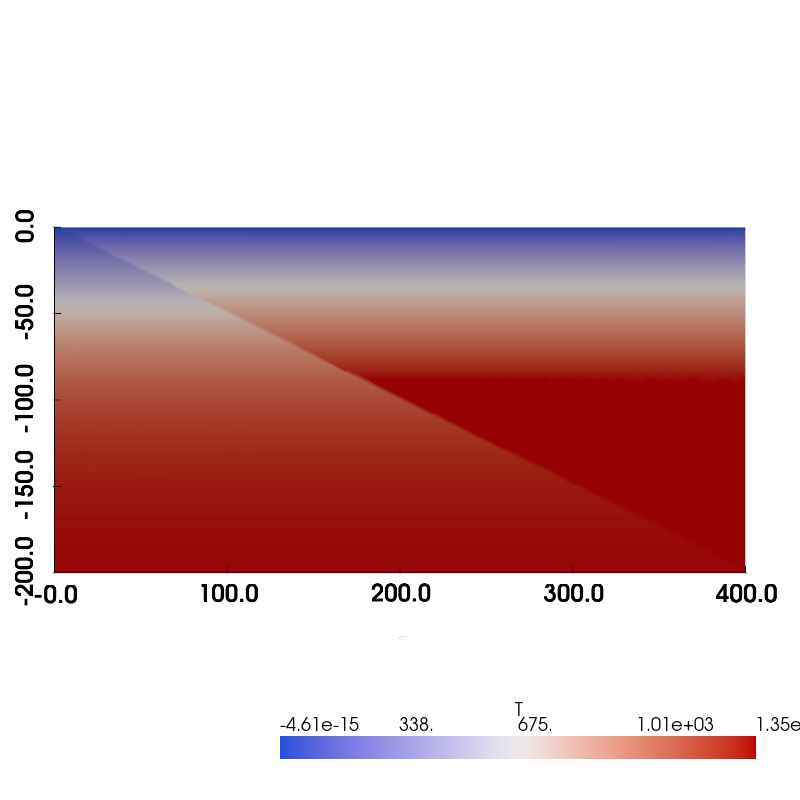

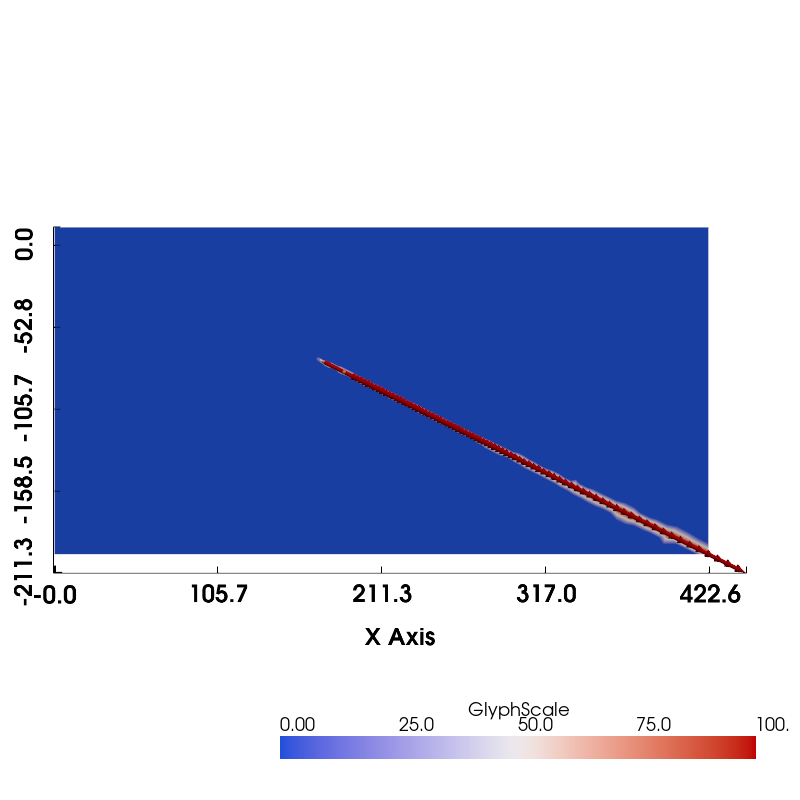

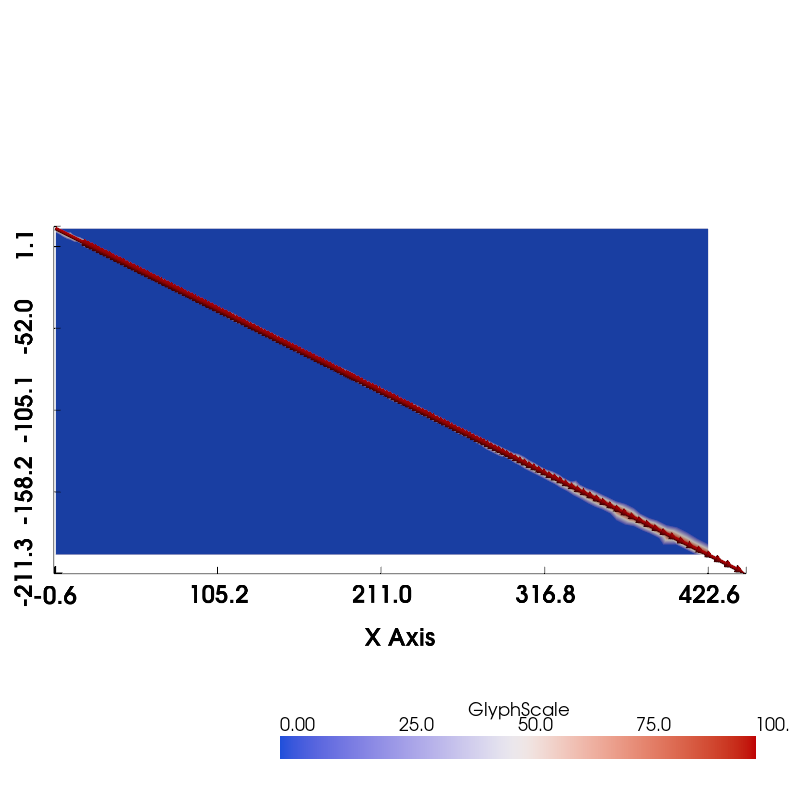

In [31]:
utils.plot_scalar(sz.T_i, scale=sz.T0)
utils.plot_vector(sz.vw_i, glyph_factor=6/utils.mps_to_mmpyr(sz.v0), scale=utils.mps_to_mmpyr(sz.v0))
utils.plot_vector(sz.vs_i, glyph_factor=6/utils.mps_to_mmpyr(sz.v0), scale=utils.mps_to_mmpyr(sz.v0))

#### Isoviscous (Case 1)

As the setup of our boundary and initial conditions looks correct we now wish to solve partial differential equations describing the thermal structure of a subduction zone in our domain.

For the velocity $\vec{v}$, and pressure, $p$, we wish to solve the Stokes equations
\begin{equation}
-\nabla \cdot \left(2\eta \frac{\nabla \vec{v} + \nabla \vec{v}^T}{2} \right) + \nabla p = 0
\end{equation}
\begin{equation}
\nabla \cdot \vec{v} = 0
\end{equation}
for an incompressible viscous fluid where $\vec{v}$ can be the wedge velocity, $\vec{v}_w$ (`wedge_vw_i`), or the slab velocity $\vec{v}_s$ (`slab_vs_i`), and similarly $p$ can be the wedge pressure, $p_w$ (`wedge_pw_i`), or the slab pressure $p_s$ (`slab_ps_i`).  $\eta$ is the non-dimensional viscosity.

Our goal is to discretize this system of equations using finite elements such that we have systems like
\begin{align}
S_s u_s = S_s \left(\begin{array}{c}\vec{v}\\p\end{array}\right) = f_s
\end{align}
where $S_s = S_s(u_{s_t}, u_{s_a})$ is a bilinear form of the combined velocity-pressure test $u_{s_t}$ and trial $u_{s_a}$ functions that will be used to assemble a left-hand side matrix and $f_s = f_s(u_{s_t})$ is a linear form that will be used to describe a right-hand side vector in a matrix-vector equation for the velocity-pressure solution $u_s = \left(\vec{v}, p\right)^T$.

To get this form we multiply the Stokes equations through by the test function $u_t = \left(\vec{v}_{w_t}, p_{w_t}\right)^T$, integrate by parts, and apply appropriate boundary conditions to the resulting boundary integrals (in this case we can just drop them all).  

Doing this in the wedge (using the subscript $w$) we get
\begin{align}
S_{s_w} =& K_{s_w} + G_{s_w} + D_{s_w} \\
f_{s_w} =& \int_{\text{wedge}} u_{w_t} 0 dx
\end{align}
where
\begin{align}
K_{s_w} =&  \int_{\text{wedge}} \left[ \left(\frac{\nabla\vec{v}_{w_t} + \nabla\vec{v}_{w_t}^T}{2}\right):2\eta\left(\frac{\nabla\vec{v}_{w_a} + \nabla\vec{v}_{w_a}^T}{2}\right) \right] dx \\
G_{s_w} =&  -  \int_{\text{wedge}} \nabla \cdot \vec{v}_{w_t} p_{w_a} dx \\
D_{s_w} =& -  \int_{\text{wedge}}  p_{w_t} \nabla \cdot \vec{v}_{w_a} dx
\end{align}
and similarly in the slab (using the subscript $s$) we get
\begin{align}
S_{s_s} =& K_{s_s} + G_{s_s} + D_{s_s} \\
f_{s_s} =& \int_{\text{slab}} u_{s_t} 0 dx
\end{align}
where
\begin{align}
K_{s_s} =&  \int_{\text{slab}} \left[ \left(\frac{\nabla\vec{v}_{s_t} + \nabla\vec{v}_{s_t}^T}{2}\right):2\eta\left(\frac{\nabla\vec{v}_{s_a} + \nabla\vec{v}_{s_a}^T}{2}\right) \right] dx \\
G_{s_s} =&  -  \int_{\text{slab}} \nabla \cdot \vec{v}_{s_t} p_{s_a} dx \\
D_{s_s} =& -  \int_{\text{slab}}  p_{s_t} \nabla \cdot \vec{v}_{s_a} dx
\end{align}

We can generalize these forms into the function `stokes_forms` and add it to our `SubductionProblem` class.


In [32]:
class SubductionProblem(SubductionProblem):
    def stokes_forms(self, vp_t, vp_a, mesh, eta=1):
        """
        Return the forms Ss and fs for the matrix problem Ss*us = fs for the Stokes problems
        given the test and trial functions and the mesh.

        Arguments:
          * vp_t - velocity-pressure test function
          * vp_a - velocity-pressure trial function
          * mesh - mesh

        Keyword Arguments:
          * eta  - viscosity (defaults to 1 for isoviscous)

        Returns:
          * Ss - lhs bilinear form for the Stokes problem
          * fs - rhs linear form for the Stokes problem
        """
        (v_t, p_t) = ufl.split(vp_t)
        (v_a, p_a) = ufl.split(vp_a)
        # the stiffness block
        Ks = ufl.inner(ufl.sym(ufl.grad(v_t)), 2*eta*ufl.sym(ufl.grad(v_a)))*ufl.dx
        # gradient of pressure
        Gs = -ufl.div(v_t)*p_a*ufl.dx
        # divergence of velcoity
        Ds = -p_t*ufl.div(v_a)*ufl.dx
        # combined matrix form
        Ss = Ks + Gs + Ds
        # this problem has no rhs so create a dummy form by multiplying by a zero constant
        zero_c = df.fem.Constant(mesh, df.default_scalar_type(0.0))
        fs = zero_c*(sum(v_t) + p_t)*ufl.dx
        # return the forms
        return Ss, fs


We can write a similar function (`temperature_forms_steadystate`) for the temperature forms given the steady-state temperature advection-diffusion equation
\begin{equation}
\rho c_p \vec{v} \cdot \nabla T = \nabla \cdot \left( k \nabla T \right) + H
\end{equation}
which we wish to convert into bilinear, $S_T = S_T(T_t, T_a)$, and linear, $f_T = f_T(T_t)$, forms, such that:
\begin{equation}
S_T T = f_T
\end{equation}

Due to the variation of the material parameters and the velocity Functions across the domain, $S_s$ is compiled from several integrals of different subregions of the domain
\begin{align}
S_T =& \int_{\text{wedge}} \left[ T_t \rho_m \vec{v}_w\cdot\nabla T_a + \nabla T_t \cdot k_m\nabla T_a \right] dx \\
& + \int_{\text{slab}} \left[ T_t \rho_m \vec{v}_s\cdot\nabla T_a + \nabla T_t \cdot k_m\nabla T_a \right] dx \\
& + \int_{\text{crust}} \left[ \nabla T_t \cdot k_c\nabla T_a \right] dx
\end{align}
Meanwhile $f_T$ depends on whether the case has over-riding continental
\begin{equation}
f_T = \int_{\text{upper crust}} T_t H_1 dx + \int_{\text{lower crust}} T_t H_2 dx
\end{equation}
or oceanic
\begin{equation}
f_T = \int T_t 0 dx
\end{equation}
crust.



In [33]:
class SubductionProblem(SubductionProblem):
    def temperature_forms_steadystate(self):
        """
        Return the forms ST and fT for the matrix problem ST*T = fT for the steady-state 
        temperature advection-diffusion problem.

        Returns:
          * ST - lhs bilinear form for the temperature problem
          * fT - rhs linear form for the temperature problem
        """
        # integration measures that know about the cell and facet tags

        # advection diffusion in the slab
        STs = (self.T_t*self.rhom*self.cp*ufl.inner(self.vs_i, ufl.grad(self.T_a)) + \
               ufl.inner(ufl.grad(self.T_a), self.km*ufl.grad(self.T_t)))*self.dx(self.slab_rids)
        # advection diffusion in the wedge
        STw = (self.T_t*self.rhom*self.cp*ufl.inner(self.vw_i, ufl.grad(self.T_a)) + \
               ufl.inner(ufl.grad(self.T_a), self.km*ufl.grad(self.T_t)))*self.dx(self.wedge_rids)
        # just diffusion in the crust
        STc = ufl.inner(ufl.grad(self.T_a), self.kc*ufl.grad(self.T_t))*self.dx(self.crust_rids)
        # the complete bilinear form
        ST  = STs + STw + STc
        if self.sztype=='continental':
            # if the sztype is 'continental' then put radiogenic heating in the rhs form
            lc_rids = tuple([geom.crustal_layers['Crust']['rid']])
            uc_rids = tuple([geom.crustal_layers['UpperCrust']['rid']])
            fT  = self.T_t*self.H1*self.dx(uc_rids) + self.T_t*self.H2*self.dx(lc_rids)
        else:
            # if the sztype is 'oceanic' then create a zero rhs form
            zero_c = df.fem.Constant(self.mesh, df.default_scalar_type(0.0))
            fT = self.T_t*zero_c*self.dx
        # return the forms
        return ST, fT


In the isoviscous case, $\eta$ = 1 (`eta = 1`), so only the temperature depends on the velocity (and not vice-versa).  So to solve the full system of equations we only need to solve the two velocity-pressure systems once (in `solve_stokes_isoviscous`) before solving the temperature to get a fully converged solution for all variables (in `solve_steadystate_isoviscous`).

In [34]:
class SubductionProblem(SubductionProblem):
    def solve_stokes_isoviscous(self, petsc_options=None):
        """
        Solve the Stokes problems assuming an isoviscous rheology.

        Keyword Arguments:
          * petsc_options - a dictionary of petsc options to pass to the solver (defaults to mumps)
        """
        if petsc_options is None:
            petsc_options={"ksp_type": "preonly", 
                           "pc_type" : "lu", 
                           "pc_factor_mat_solver_type" : "mumps"}

        # retrive the Stokes forms for the wedge
        Ssw, fsw = self.stokes_forms(self.wedge_vpw_t, self.wedge_vpw_a, self.wedge_submesh)
        problem_vpw = df.fem.petsc.LinearProblem(Ssw, fsw, bcs=self.bcs_vpw, u=self.wedge_vpw_i, 
                                                 petsc_options=petsc_options)
        
        # retrive the Stokes forms for the slab
        Sss, fss = self.stokes_forms(self.slab_vps_t, self.slab_vps_a, self.slab_submesh)
        problem_vps = df.fem.petsc.LinearProblem(Sss, fss, bcs=self.bcs_vps, u=self.slab_vps_i,
                                                 petsc_options=petsc_options)

        # solve the Stokes problems
        self.wedge_vpw_i = problem_vpw.solve()
        self.slab_vps_i = problem_vps.solve()

        # interpolate the solutions to the whole mesh
        self.update_v_functions()
        
    def solve_steadystate_isoviscous(self, petsc_options=None):
        """
        Solve the coupled temperature-velocity-pressure problem assuming an isoviscous rheology

        Keyword Arguments:
          * petsc_options - a dictionary of petsc options to pass to the solver (defaults to mumps)
        """
        if petsc_options is None:
            petsc_options={"ksp_type": "preonly", 
                           "pc_type" : "lu", 
                           "pc_factor_mat_solver_type" : "mumps"}

        # first solve both Stokes systems
        self.solve_stokes_isoviscous(petsc_options=petsc_options)

        # retrieve the temperature forms
        ST, fT = self.temperature_forms_steadystate()
        problem_T = df.fem.petsc.LinearProblem(ST, fT, bcs=self.bcs_T, u=self.T_i,
                                               petsc_options=petsc_options)
        # and solve the temperature problem
        self.T_i = problem_T.solve()

        # only update the pressure at the end as it is not necessary earlier
        self.update_p_functions()

So now we have a full description of the isoviscous problem for benchmark case 1 but need some diagnostics to test it.

The benchmark focuses on dimensional metrics representing the averaged thermal and velocity structures near the coupling point
where gradients in velocity and temperature are high.

The first metric is
the slab temperature at 100 km depth, $T_{(200,-100)}^*$
\begin{equation}
    T_{(200,-100)}^* ~=~ T_0 T(x=200,y=-100)
\end{equation}

The second metric is the average integrated temperature $\overline{T}_s^*$ along the slab surface between 
depths $z_{s,1}$=70 and $z_{s,2}$=120, that is
\begin{equation}
    \overline{T}_s^* ~=~ T_0 \frac{\int_{s_1}^{s_2} T ds}{\int_{s_1}^{s_2} ds}
\end{equation}
where $s$ is distance along the slab top from the trench,
$s_1$=$\sqrt{5z_{s,1}^2}$=156.5248 and $s_2$=$\sqrt{5z_{s,2}^2}$=268.32816.

The third metric is
the volume-averaged temperature $\overline{T}_w^*$ in the mantle wedge corner below the Moho, 
$z$=$z_2$ and above where the slab surface, $z$=$z_\text{slab}(x)$, 
is between 
$z_{s,1}$ and $z_{s,2}$ as defined above
\begin{equation}
    \overline{T}_w^* ~=~ T_0 \frac{\int_{x=140}^{x=240}\int_{z=z_2}^{z=z_\text{slab}(x)} \tilde{T} dz dx}{\int_{x=140}^{x=240}\int_{z=z_2}^{z=z_\text{slab}(x)} dz dx}
\end{equation}
where $z_\text{slab}(x)$=$x/2$.

The final metric is the root-mean-squared averaged velocity $V_{\text{rms},w}^*$ in the same volume as the third metric, that is
\begin{equation}
    V_{\text{rms},w}^*~=~ v_0 
    \sqrt{ 
     \frac {\int_{x=140}^{x=240}\int_{z=z_2}^{z=z_\text{slab}} \left( \tilde{\vec{v}}\cdot\tilde{\vec{v}} \right) dzdx}
            {\int_{x=140}^{x=240}\int_{z=z_2}^{z=z_\text{slab}(x)} dz dx}
    }.
\end{equation}

These are all functional forms that return a single scalar and can be easily represented using UFL, just like we did the equations.  We do that in the function `get_diagnostics`.

In [35]:
class SubductionProblem(SubductionProblem):
    def get_diagnostics(self):
        """
        Retrieve the benchmark diagnostics.

        Returns:
          * Tpt       - spot temperature on the slab at 100 km depth
          * Tslab     - average temperature along the diagnostic region of the slab surface
          * Twedge    - average temperature in the diagnostic region of the wedge
          * vrmswedge - average rms velocity in the diagnostic region of the wedge
        """
        # work out location of spot tempeterature on slab and evaluate T
        xpt = np.asarray(self.geom.slab_spline.intersecty(-100.0)+[0.0])
        Tpt = self.T0*self.T_i.eval(xpt, utils.get_first_cells(xpt, self.mesh)[0])[0]
        print("T_(200,-100) = {:.2f} deg C".format(Tpt,))

        # a unit constant to evaluate slab length and wedge area
        one_c = df.fem.Constant(self.mesh, df.default_scalar_type(1.0))

        # evaluate average T along diagnostic section of slab
        slab_diag_sids = tuple([self.geom.wedge_dividers['WedgeFocused']['slab_sid']])
        Tslab = self.T0*df.fem.assemble_scalar(df.fem.form(self.T_i*self.dS(slab_diag_sids)))\
                        /df.fem.assemble_scalar(df.fem.form(one_c*self.dS(slab_diag_sids)))
        print("T_slab = {:.2f} deg C".format(Tslab,))
        
        wedge_diag_rids = tuple([self.geom.wedge_dividers['WedgeFocused']['rid']])
        wedge_diag_area = df.fem.assemble_scalar(df.fem.form(one_c*self.dx(wedge_diag_rids)))

        # evaluate average T in wedge diagnostic region
        Twedge = self.T0*df.fem.assemble_scalar(df.fem.form(self.T_i*self.dx(wedge_diag_rids)))\
                         /wedge_diag_area
        print("T_wedge = {:.2f} deg C".format(Twedge,))

        # evaluate average vrms in wedge diagnostic region
        vrmswedge = np.sqrt(df.fem.assemble_scalar(df.fem.form(ufl.inner(self.vw_i, self.vw_i)*self.dx(wedge_diag_rids)))\
                            /wedge_diag_area)*utils.mps_to_mmpyr(self.v0)
        print("V_rms,w = {:.2f} mm/yr".format(vrmswedge,))

        # return results
        return Tpt, Tslab, Twedge, vrmswedge


Because we have added functions to the class we need to re-instantiate it, which unfortunately means a lot of output again during mesh generation.

In [36]:
sz = SubductionProblem(geom, A=A, Vs=Vs, sztype=sztype, qs=qs)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
I

But now we can solve the isoviscous problem.

In [38]:
sz.solve_steadystate_isoviscous()

And get the diagnostic output to compare against the benchmark.

In [56]:
diag = sz.get_diagnostics()
T_ndof = sz.V_T.dofmap.index_map.size_global * sz.V_T.dofmap.index_map_bs

print('')
print('{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}'.format('resscale', 'T_ndof', 'T_{200,-100}', 'Tbar_s', 'Tbar_w', 'Vrmsw'))
print('{:<12.4g} {:<12d} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}'.format(resscale, T_ndof, diag[0], diag[1], diag[2], diag[3]))

T_(200,-100) = 517.17 deg C
T_slab = 451.95 deg C
T_wedge = 927.02 deg C
V_rms,w = 34.64 mm/yr

resscale     T_ndof       T_{200,-100} Tbar_s       Tbar_w       Vrmsw       
5            5812         517.1668     451.9452     927.0205     34.6379     


For comparison here are the values reported using [TerraFERMA](https://terraferma.github.io) in [Wilson & van Keken, 2023](http://dx.doi.org/10.1186/s40645-023-00588-6):

| `resscale` | $T_{\text{ndof}} $ | $T_{(200,-100)}^*$ | $\overline{T}_s^*$ | $ \overline{T}_w^* $ |  $V_{\text{rms},w}^*$ |
| - | - | - | - | - | - |
| 2.0 | 21403  | 517.17 | 451.83 | 926.62 | 34.64 |
| 1.0 | 83935  | 516.95 | 451.71 | 926.33 | 34.64 |
| 0.5 | 332307 | 516.86 | 451.63 | 926.15 | 34.64 |

We can also plot the temperature and velocity solutions.

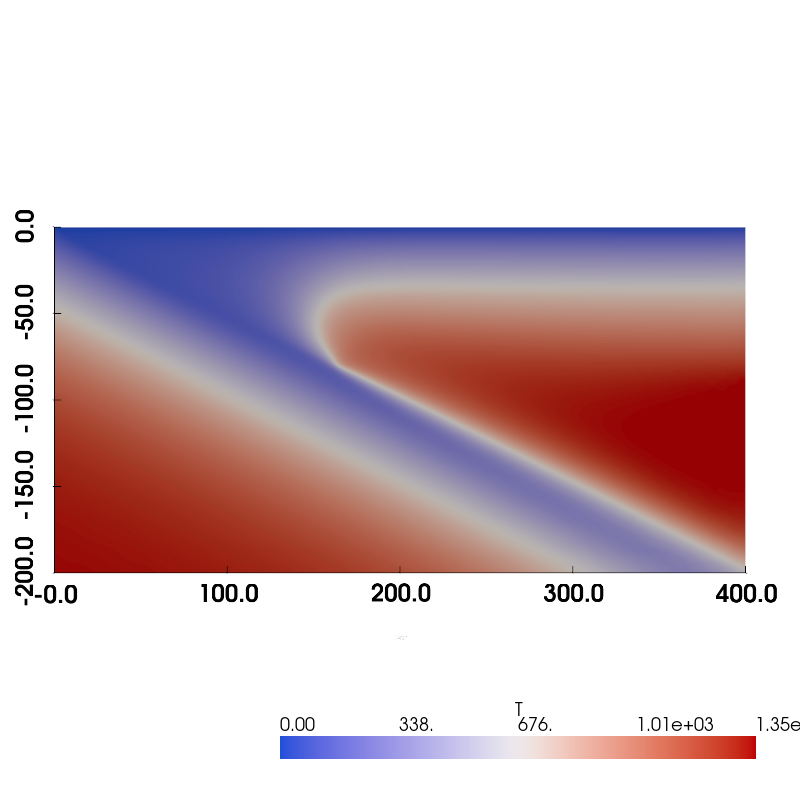

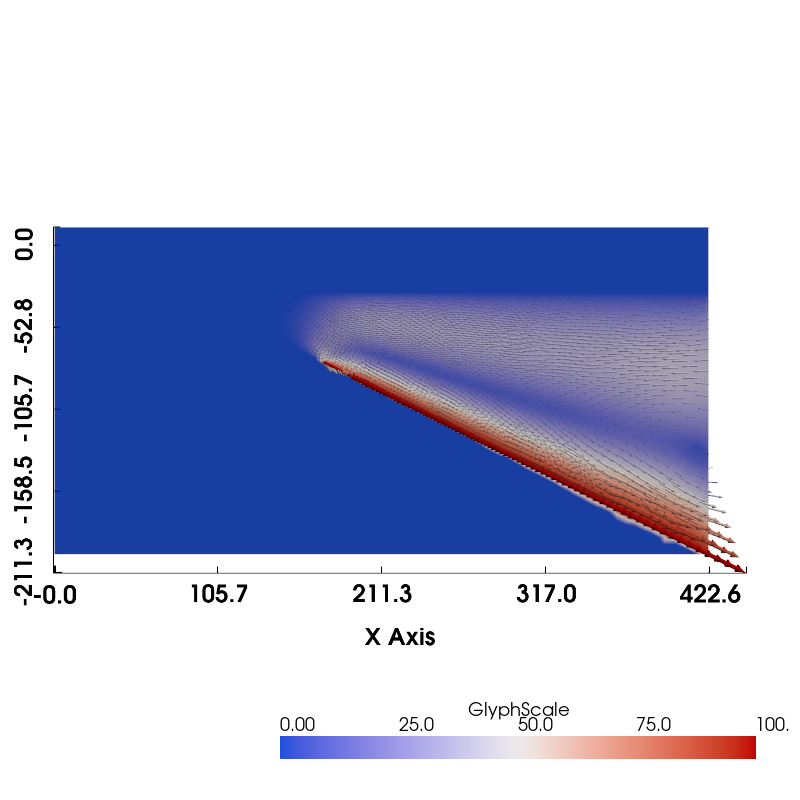

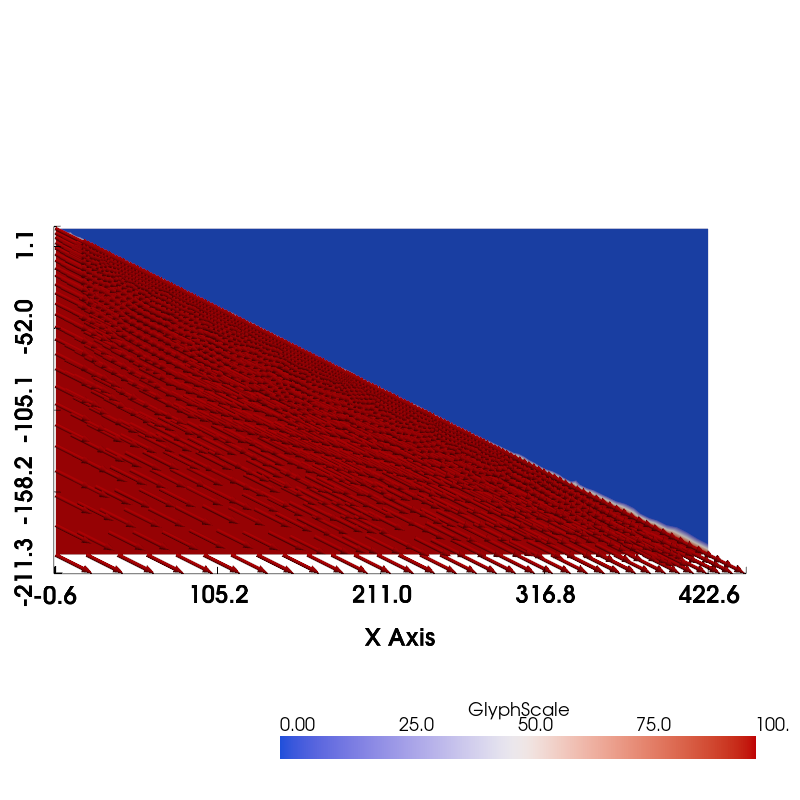

In [57]:
utils.plot_scalar(sz.T_i, scale=sz.T0)
utils.plot_vector(sz.vw_i, glyph_factor=6/utils.mps_to_mmpyr(sz.v0), scale=utils.mps_to_mmpyr(sz.v0))
utils.plot_vector(sz.vs_i, glyph_factor=6/utils.mps_to_mmpyr(sz.v0), scale=utils.mps_to_mmpyr(sz.v0))

The output can also be saved to disk and opened with other visualization software (e.g. [Paraview](https://www.paraview.org/) using code like
```
output_folder = pathlib.Path("output")
output_folder.mkdir(exist_ok=True, parents=True)
filename = output_folder / "<file base name>"
with df.io.VTXWriter(sz.mesh.comm, filename.with_suffix(".bp"), [sz.T_i, sz.vs_i, sz.vw_i]) as vtx:
    vtx.write(0.0)
```
where `<file base name>` needs to be replaced with a suitable filename.

It's also common to want to interogate the temperature at various points in the domain or along the slab.  Here we provide an example function for doing that that plots the slab temperature along the slab surface and along the slab Moho at 7km depth (into the slab).

In [65]:
def plot_slab_temperatures(sz):
    """
    Plot the slab surface and Moho (7 km slab depth)

    Arguments:
      * sz - a solved SubductionProblem instance
    """
    # get some points along the slab
    slabpoints = np.array([[curve.points[0].x, curve.points[0].y, 0.0] for curve in sz.geom.slab_spline.interpcurves])
    # do the same along a spline deeper in the slab
    slabmoho = copy.deepcopy(sz.geom.slab_spline)
    slabmoho.translatenormalandcrop(-7.0)
    slabmohopoints = np.array([[curve.points[0].x, curve.points[0].y, 0.0] for curve in slabmoho.interpcurves])
    # set up a figure
    fig = pl.figure()
    ax = fig.gca()
    # plot the slab temperatures
    ax.plot(sz.T_i.eval(slabpoints, utils.get_first_cells(slabpoints, sz.mesh))[:,0], -slabpoints[:,1], label='slab surface')
    # plot the moho temperatures
    ax.plot(sz.T_i.eval(slabmohopoints, utils.get_first_cells(slabmohopoints, sz.mesh))[:,0], -slabmohopoints[:,1], label='slab moho')
    # labels, title etc.
    ax.set_xlabel('T ($^\circ$C)')
    ax.set_ylabel('z (km)')
    ax.set_title('Slab surface and Moho temperatures')
    ax.legend()
    ax.invert_yaxis()
    fig.show()

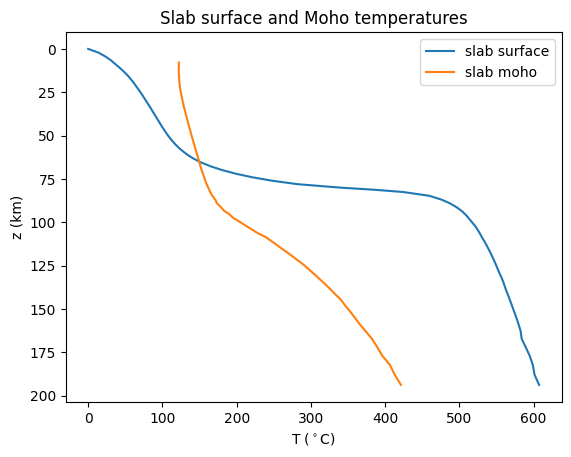

In [67]:
plot_slab_temperatures(sz)

#### Dislocation Creep Viscosity (Case 2)

For case 2 we need to define a dislocation creep viscosity law

a function of temperature and 
strain rate following a simplified creep law for dislocation creep in dry olivine from \citet{KaratoWu1993}
\begin{linenomath*}
\begin{equation}
\eta^*_\text{disl}~=~ A_\eta^* \exp \left( \frac{E^*}{nR^*(T^*+T^*_a)} \right) {{\dot{\epsilon}_{II}}}^{*\frac{1-n}{n}}
\label{eq:olivinerheology}
\end{equation}
\end{linenomath*}
where $A_\eta^*$ is a prefactor, $E^*$ is the activation energy, $R^*$ is the gas constant, $n$ is a powerlaw index, 
%PVK add
$T^*_a$
a linear approximation of an adiabatic temperature
using a gradient of 0.3$^\circ$C/km with $T^*_a$=0 at the top of the model (which may not be at $z^*$=0 due to assumptions of ocean bathymetry as we will see in section \ref{section:geometryandboundaryconditions})
%PvK modified: part~III),
and $\dot{\epsilon}_{II}^*$ is the second invariant of the 
deviatoric strain-rate tensor (also known as the effective deviatoric strain rate)
\begin{linenomath*}
\begin{equation}
\dot{\epsilon}_{II}^*~=~ \sqrt{\frac{1}{2} \dot{\boldsymbol\epsilon}^*:\dot{\boldsymbol\epsilon}^*}
\label{eq:secondinvariant}
\end{equation}
\end{linenomath*}
Since the dynamical range of the viscosity (\ref{eq:olivinerheology}) is large over the temperature contrast across
subduction zones it is common practice to cap the viscosity at some arbitrary maximum $\eta^*_\text{max}$ so that in the variable viscosity case
\begin{linenomath*}
\begin{equation}
\eta^*~=~ \left( \frac{1}{\eta^*_\text{disl}} ~+~ \frac{1}{\eta^*_\text{max}}\right)^{-1}
\label{eq:viscositycap}
\end{equation}
\end{linenomath*}

In [ ]:
class SubductionProblem(SubductionProblem):
    def etadisl(self, v_i, T_i):
        """
        Return a dislocation creep viscosity given a velocity and temperature

        Arguments:
          * v_i - velocity Function
          * T_i - temperature Function

        Returns:
          * eta - viscosity ufl description
        """
        
        # get the mesh
        mesh = v_i.function_space.mesh
        x = ufl.SpatialCoordinate(mesh)
        zero_c = df.fem.Constant(mesh, df.default_scalar_type(0.0))
        deltaztrench_c = df.fem.Constant(mesh, df.default_scalar_type(self.deltaztrench))
        deltazsurface = ufl.operators.MinValue(ufl.operators.MaxValue(self.deltaztrench*(1. - x[0]/max(self.deltaxcoast, np.finfo(df.default_scalar_type).eps)), zero_c), deltaztrench_c)
        z = -(x[1]+deltazsurface)
        
        # dimensional temperature in Kelvin with an adiabat added
        Tdim = utils.nondim_to_K(T_i) + 0.3*z
        
        E_c          = df.fem.Constant(mesh, df.default_scalar_type(self.E))
        invetamax_c  = df.fem.Constant(mesh, df.default_scalar_type(self.eta0/self.etamax))
        neII         = (self.nsigma-1.0)/self.nsigma
        invetafact_c = df.fem.Constant(mesh, df.default_scalar_type(self.eta0*(self.e0**neII)/self.Aeta))
        neII_c       = df.fem.Constant(mesh, df.default_scalar_type(neII))
    
        # strain rate
        edot = ufl.sym(ufl.grad(v_i))
        eII  = ufl.sqrt(0.5*ufl.inner(edot, edot))
        # inverse dimensionless dislocation creep viscosity
        invetadisl = invetafact_c*ufl.exp(-E_c/(self.nsigma*self.R*Tdim))*(eII**neII_c)
        # inverse dimensionless effective viscosity
        inveta = invetadisl + invetamax_c
        # "harmonic mean" viscosity (actually twice the harmonic mean)
        return 1./inveta

    def project_dislocationcreep_viscosity(self, p_eta=0, petsc_options=None):
        """
        Project the dislocation creep viscosity to the mesh.

        Keyword Arguments:
          * peta          - finite element degree of viscosity Function (defaults to 0)
          * petsc_options - a dictionary of petsc options to pass to the solver (defaults to mumps)

        Returns:
          * eta_i - the viscosity Function
        """
        if petsc_options is None:
            petsc_options={"ksp_type": "preonly", 
                           "pc_type" : "lu", 
                           "pc_factor_mat_solver_type" : "mumps"}
        # set up the functionspace
        V_eta = df.fem.functionspace(self.mesh, ("DG", p_eta))
        # declare the domain wide Function
        eta_i = df.fem.Function(V_eta)
        # set it to etamax everywhere (will get overwritten)
        eta_i.x.array[:] = self.etamax/self.eta0
        
        def solve_viscosity(v_i, T_i, cell_map, reverse_cell_map):
            """
            Solve for the viscosity in subdomains and interpolate it to the parent Function
            """
            mesh = T_i.function_space.mesh
            Vwedge_eta = df.fem.functionspace(mesh, ("DG", p_eta))
            eta_a = ufl.TrialFunction(Vwedge_eta)
            eta_t = ufl.TestFunction(Vwedge_eta)
            Seta = eta_t*eta_a*ufl.dx
            feta = eta_t*self.etadisl(v_i, T_i)*ufl.dx
            problem = df.fem.petsc.LinearProblem(Seta, feta, petsc_options=petsc_options)
            leta_i = problem.solve()
            eta_i.interpolate(leta_i, cells=cell_map, cell_map=reverse_cell_map)

        # solve in the wedge
        solve_viscosity(self.wedge_vw_i, self.wedge_T_i, \
                        self.wedge_cell_map, self.wedge_reverse_cell_map)
        # solve in the slab
        solve_viscosity(self.slab_vs_i, self.slab_T_i, \
                        self.slab_cell_map, self.slab_reverse_cell_map)

        # return the viscosity
        return eta_i
    

In [ ]:
class SubductionProblem(SubductionProblem):
    def solve_steadystate_dislocationcreep(self, rtol=5.e-6, atol=5.e-9, maxits=50,
                                           petsc_options=None):
        """
        Solve the Stokes problems assuming a dislocation creep rheology.

        Keyword Arguments:
          * rtol          - nonlinear iteration relative tolerance
          * atol          - nonlinear iteration absolute tolerance
          * maxits        - maximum number of nonlinear iterations
          * petsc_options - a dictionary of petsc options to pass to the solver (defaults to mumps)
        """
        if petsc_options is None:
            petsc_options={"ksp_type": "preonly", 
                           "pc_type" : "lu", 
                           "pc_factor_mat_solver_type" : "mumps"}
            
        # first solve the isoviscous problem
        self.solve_stokes_isoviscous(petsc_options=petsc_options)

        # retrieve the temperature forms
        ST, fT = self.temperature_forms_steadystate()
        problem_T = df.fem.petsc.LinearProblem(ST, fT, bcs=self.bcs_T, u=self.T_i,
                                               petsc_options=petsc_options)
        # and solve the temperature problem, given the isoviscous Stokes solution
        self.T_i = problem_T.solve()
        self.update_T_functions()
        
        # retrive the non-linear Stokes forms for the wedge
        Ssw, fsw = self.stokes_forms(self.wedge_vpw_t, self.wedge_vpw_a, \
                                     self.wedge_submesh, eta=self.etadisl(self.wedge_vw_i, self.wedge_T_i))
        problem_vpw = df.fem.petsc.LinearProblem(Ssw, fsw, bcs=self.bcs_vpw, u=self.wedge_vpw_i, 
                                                 petsc_options=petsc_options)

        # retrive the non-linear Stokes forms for the slab
        Sss, fss = self.stokes_forms(self.slab_vps_t, self.slab_vps_a, \
                                     self.slab_submesh, eta=self.etadisl(self.slab_vs_i, self.slab_T_i))
        problem_vps = df.fem.petsc.LinearProblem(Sss, fss, bcs=self.bcs_vps, u=self.slab_vps_i,
                                                 petsc_options=petsc_options)

        # define the non-linear residual for the wedge velocity-pressure
        rw = ufl.action(Ssw, self.wedge_vpw_i) - fsw
        # define the non-linear residual for the slab velocity-pressure
        rs = ufl.action(Sss, self.slab_vps_i) - fss
        # define the non-linear residual for the temperature
        rT = ufl.action(ST, self.T_i) - fT

        def calculate_residual():
            """
            Return the total residual of the problem
            """
            rw_vec = df.fem.assemble_vector(df.fem.form(rw))
            df.fem.set_bc(rw_vec.array, self.bcs_vpw, scale=0.0)
            rs_vec = df.fem.assemble_vector(df.fem.form(rs))
            df.fem.set_bc(rs_vec.array, self.bcs_vps, scale=0.0)
            rT_vec = df.fem.assemble_vector(df.fem.form(rT))
            df.fem.set_bc(rT_vec.array, self.bcs_T, scale=0.0)
            r = np.sqrt(rw_vec.petsc_vec.norm()**2 + \
                        rs_vec.petsc_vec.norm()**2 + \
                        rT_vec.petsc_vec.norm()**2)
            return r

        # calculate the initial residual
        r = calculate_residual()
        r0 = r
        rrel = r/r0  # 1
        print("{:<11} {:<12} {:<17}".format('Iteration','Residual','Relative Residual'))
        print("-"*42)

        # iterate until the residual converges (hopefully)
        it = 0
        print("{:<11} {:<12.6g} {:<12.6g}".format(it, r, rrel,))
        while rrel > rtol and r > atol:
            if it > maxits: break
            # solve for v & p and interpolate it
            self.wedge_vpw_i = problem_vpw.solve()
            self.slab_vps_i  = problem_vps.solve()
            self.update_v_functions()
            # solve for T and interpolate it
            self.T_i = problem_T.solve()
            self.update_T_functions()
            # calculate a new residual
            r = calculate_residual()
            rrel = r/r0
            it += 1
            print("{:<11} {:<12.6g} {:<12.6g}".format(it, r, rrel,))

        # check for convergence failures
        if it > maxits:
            raise Exception("Nonlinear iteration failed to converge after {} iterations (maxits = {}), r = {} (atol = {}), rrel = {} (rtol = {}).".format(it, \
                                                                                                                                                          maxits, \
                                                                                                                                                          r, \
                                                                                                                                                          rtol, \
                                                                                                                                                          rrel, \
                                                                                                                                                          rtol,))

        # only update the pressure at the end as it is not necessary earlier
        self.update_p_functions()

In [ ]:
io_depth_2 = 154.0
geom_case2 = create_sz_geometry(slab, resscale, sztype, io_depth_2, extra_width, 
                                coast_distance, lc_depth, uc_depth)
sz_case2 = SubductionProblem(geom_case2, A=A, Vs=Vs, sztype=sztype, qs=qs)
print("\nSolving steady state flow with dislocation creep rheology...")
sz_case2.solve_steadystate_dislocationcreep()
print("\nGetting diagnostics...")
sz_case2.get_diagnostics()

In [ ]:
utils.plot_scalar(sz_case2.T_i)
utils.plot_vector(sz_case2.vw_i)
utils.plot_vector(sz_case2.vs_i)

In [ ]:
eta_i = sz_case2.project_dislocationcreep_viscosity()
utils.plot_scalar(eta_i, scale=sz_case2.eta0, log_scale=True, show_edges=True)

In [ ]:
plot_slab_temperatures(sz_case2)

In [ ]:
allsz_filename = os.path.join(os.pardir, "data", "all_sz.json")
with open(allsz_filename, "r") as fp:
    allsz_params = json.load(fp)

In [ ]:
szdict = allsz_params['01_Alaska_Peninsula']
slab_ak = create_slab(szdict['xs'], szdict['ys'], resscale, szdict['lc_depth'])
geom_ak = create_sz_geometry(slab_ak, resscale, szdict['sztype'], szdict['io_depth'], szdict['extra_width'], 
                             szdict['coast_distance'], szdict['lc_depth'], szdict['uc_depth'])
sz_ak = SubductionProblem(geom_ak, **szdict)
print("\nSolving steady state flow with isoviscous rheology...")
sz_ak.solve_steadystate_dislocationcreep()
print("\nGetting diagnostics...")
sz_ak.get_diagnostics()

In [ ]:
utils.plot_scalar(sz_ak.T_i)

In [ ]:
sz_ak.geom.plot()

In [ ]:
szdict = allsz_params['19_N_Antilles']
slab_ant = create_slab(szdict['xs'], szdict['ys'], resscale, szdict['lc_depth'])
geom_ant = create_sz_geometry(slab_ant, resscale, szdict['sztype'], szdict['io_depth'], szdict['extra_width'], 
                             szdict['coast_distance'], szdict['lc_depth'], szdict['uc_depth'])
sz_ant = SubductionProblem(geom_ant, **szdict)
print("\nSolving steady state flow with isoviscous rheology...")
sz_ant.solve_steadystate_dislocationcreep()
print("\nGetting diagnostics...")
sz_ant.get_diagnostics()

In [ ]:
utils.plot_scalar(sz_ant.T_i)
eta_i = sz_ant.project_dislocationcreep_viscosity()
utils.plot_scalar(eta_i, scale=sz_ant.eta0, log_scale=True, show_edges=True)

In [ ]:
sz_ant.geom.plot()

In [ ]:
utils.plot_mesh(sz_ant.mesh)